# Mental Health in Technology-related Jobs
**Author: Mariana Del Pozo**

A case study for DLBDSMLUSL01 Machine Learning – Unsupervised Learning and Feature Engineering course at IU International University of Applied Sciences.


*Note: all markdown cells are numbered by their respective sections in the case study, and therefore might appear without linear order.*

### 1. Introduction
The intersection of corporate technology environments and mental health has become a focal point for organizational development. As the pace of innovation accelerates, the cognitive load on technology professionals increases, often manifesting as burnout or turnover.

This analysis moves beyond reactive crisis management to pre-emptive mitigation strategies. By analyzing survey data from the **OSMI 2016 Mental Health in Tech Survey**, this analysis aim to categorize participants into distinct, interpretable cluster personas to drive targeted HR interventions.

#### 1.2 Challenges of High-Dimensional Survey Data
The primary obstacle in this analysis is the **curse of dimensionality** where an excessive number of features can dilute meaningful patterns. Furthermore, the dataset contains not only mixed-type data, but also extensive structural artifacts driven by questionnaire valid skips, requiring rigorous preprocessing to disentangle structural zeros from genuine behavioral signals.

In [181]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import prince
import gower
import re
import csv
import warnings
import missingno as msno
import os
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score, silhouette_samples
from kmodes.kprototypes import KPrototypes
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from itertools import combinations

In [69]:
#Config
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [182]:
#Verify paths
dirs = [
    Path("data/raw"),
    Path("data/processed"),
    Path("figures")
]

for path in dirs:
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)

### 2. Methodology
#### 2.1 Dataset Overview
The analysis utilizes the Open Sourcing Mental Illness (OSMI) 2016 survey (n=1,433). The feature set covers demographics, work context, mental health history, and workplace resource availability.

In [70]:
#Data Loading
try:
    df_raw = pd.read_csv('../data/raw/mental-heath-in-tech-2016_20161114.csv')
    df_raw.shape
except FileNotFoundError:
    print('Dataset not found.')

In [71]:
#Structural Audit
df_raw.head()

"Are you self-employed?"  \
0                             0   
1                             0   
2                             0   
3                             1   
4                             0   

  How many employees does your company or organization have?  \
0                                             26-100           
1                                               6-25           
2                                               6-25           
3                                                NaN           
4                                               6-25           

   Is your employer primarily a tech company/organization?  \
0                                                1.0         
1                                                1.0         
2                                                1.0         
3                                                NaN         
4                                                0.0         

   Is your primary role within your company related to tech/IT?  \
0                                                NaN              
1                                                NaN              
2                                                NaN              
3                                                NaN              
4                                                1.0              

  Does your employer provide mental health benefits as part of healthcare coverage?  \
0                    Not eligible for coverage / N/A                                  
1                                                 No                                  
2                                                 No                                  
3                                                NaN                                  
4                                                Yes                                  

  Do you know the options for mental health care available under your employer-provided coverage?  \
0                                                NaN                                                
1                                                Yes                                                
2                                                NaN                                                
3                                                NaN                                                
4                                                Yes                                                

  Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?  \
0                                                 No                                                                                       
1                                                Yes                                                                                       
2                                                 No                                                                                       
3                                                NaN                                                                                       
4                                                 No                                                                                       

  Does your employer offer resources to learn more about mental health concerns and options for seeking help?  \
0                                                 No                                                            
1                                                Yes                                                            
2                                                 No                                                            
3                                                NaN                                                            
4                                                 No                                               

In [72]:
#Vartypes
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 63 columns):
 #   Column                                                                                                                                                                            Non-Null Count  Dtype  
---  ------                                                                                                                                                                            --------------  -----  
 0       "Are you self-employed?"                                                                                                                                                      1433 non-null   int64  
 1   How many employees does your company or organization have?                                                                                                                        1146 non-null   object 
 2   Is your employer primarily a tech company/organization?     

In [73]:
#Statistics
df_raw.describe(include='all')

"Are you self-employed?"  \
count                    1433.000000   
unique                           NaN   
top                              NaN   
freq                             NaN   
mean                        0.200279   
std                         0.400349   
min                         0.000000   
25%                         0.000000   
50%                         0.000000   
75%                         0.000000   
max                         1.000000   

       How many employees does your company or organization have?  \
count                                                1146           
unique                                                  6           
top                                                26-100           
freq                                                  292           
mean                                                  NaN           
std                                                   NaN           
min                                                   NaN           
25%                                                   NaN           
50%                                                   NaN           
75%                                                   NaN           
max                                                   NaN           

        Is your employer primarily a tech company/organization?  \
count                                         1146.000000         
unique                                                NaN         
top                                                   NaN         
freq                                                  NaN         
mean                                             0.770506         
std                                              0.420691         
min                                              0.000000         
25%                                              1.000000         
50%                                              1.000000         
75%                                              1.000000         
max                                              1.000000         

        Is your primary role within your company related to tech/IT?  \
count                                          263.000000              
unique                                                NaN              
top                                                   NaN              
freq                                                  NaN              
mean                                             0.942966              
std                                              0.232350              
min                                              0.000000              
25%                                              1.000000              
50%                                              1.000000              
75%                                              1.000000              
max                                              1.000000              

       Does your employer provide mental health benefits as part of healthcare coverage?  \
count                                                1146                                  
unique                                                  4                                  
top                                                   Yes                                  
freq                                                  531                                  
mean                                                  NaN                                  
std                                                   NaN                                  
min                                                   NaN                                  
25%                                                   NaN                                  
50%                                                   NaN                                  
75%                                                   NaN                                  
max                 

#### 2.1.2 Data Quality and Scope Assessment
To maintain analytical coherence relevant to corporate HR strategies, the scope is refined as follows:
* **Exclusion of Self-Employed:** Respondents identifying as self-employed ($n=287$) are removed as they are subject to a distinct Missing at Random (MAR) pattern regarding employer-specific questions.
* **Tech-Focus:** Non-tech roles and non-tech organizations are omitted to isolate the target population.
* **Geographic Filtering:** Granular state-level data is excluded to prevent regional bias and sparse feature spaces.
* **Free-text omission:** Open-ended text answers to follow up questions (e.g. Why not?) were removed for both ethical and dimensional reasons.

In [74]:
#Scope Reduction
df_scoped = df_raw[df_raw['    "Are you self-employed?"'] == 0].copy()

tech_filter = (
    (df_scoped['Is your employer primarily a tech company/organization?'] == 1) | 
    (df_scoped['Is your primary role within your company related to tech/IT?'] == 1)
)
df_scoped = df_scoped[tech_filter]

cols_to_drop = [
    '    "Are you self-employed?"',
    'What country do you live in?',
    'What US state or territory do you live in?',
    'What US state or territory do you work in?',
    'Why or why not?',
    'Why or why not?.1'
]

df_scoped = df_scoped.drop(columns=cols_to_drop, errors='ignore')

print(f'Final shape: {df_scoped.shape}')

Final shape: (1131, 57)


In [75]:
#Column Names
df_scoped.columns.tolist()

['How many employees does your company or organization have?',
 'Is your employer primarily a tech company/organization?',
 'Is your primary role within your company related to tech/IT?',
 'Does your employer provide mental health benefits as part of healthcare coverage?',
 'Do you know the options for mental health care available under your employer-provided coverage?',
 'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?',
 'Does your employer offer resources to learn more about mental health concerns and options for seeking help?',
 'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?',
 'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:',
 'Do you think that discussing a mental health disorder with your employer would have negative consequences?',
 'Do 

In [76]:
#Column Mapping
new_cols = {
    'How many employees does your company or organization have?': 'company_size',
    'Is your employer primarily a tech company/organization?': 'is_tech_company',
    'Is your primary role within your company related to tech/IT?': 'is_tech_role',
    'Does your employer provide mental health benefits as part of healthcare coverage?': 'benefits_coverage',
    'Do you know the options for mental health care available under your employer-provided coverage?': 'know_options',
    'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?': 'discussed_mh',
    'Does your employer offer resources to learn more about mental health concerns and options for seeking help?': 'offer_resources',
    'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?': 'anonymity_protected',
    'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:': 'leave_difficulty',
    'Do you think that discussing a mental health disorder with your employer would have negative consequences?': 'neg_consequence_employer',
    'Do you think that discussing a physical health issue with your employer would have negative consequences?': 'neg_consequence_physical',
    'Would you feel comfortable discussing a mental health disorder with your coworkers?': 'discuss_coworkers',
    'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?': 'discuss_supervisor',
    'Do you feel that your employer takes mental health as seriously as physical health?': 'mh_vs_ph',
    'Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?': 'obs_consequence_coworkers',
    'Do you have medical coverage (private insurance or state-provided) which includes treatment of \xa0mental health issues?': 'medical_coverage',
    'Do you know local or online resources to seek help for a mental health disorder?': 'know_local_resources',
    'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?': 'reveal_clients',
    'If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?': 'impacted_clients',
    'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?': 'reveal_coworkers',
    'If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?': 'impacted_coworkers',
    'Do you believe your productivity is ever affected by a mental health issue?': 'productivity_affected',
    'If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?': 'percent_work_time_affected',
    'Do you have previous employers?': 'has_prev_employer',
    'Have your previous employers provided mental health benefits?': 'prev_benefits',
    'Were you aware of the options for mental health care provided by your previous employers?': 'prev_know_options',
    'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?': 'prev_discussed_mh',
    'Did your previous employers provide resources to learn more about mental health issues and how to seek help?': 'prev_resources',
    'Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?': 'prev_anonymity',
    'Do you think that discussing a mental health disorder with previous employers would have negative consequences?': 'prev_neg_consequence',
    'Do you think that discussing a physical health issue with previous employers would have negative consequences?': 'prev_neg_consequence_physical',
    'Would you have been willing to discuss a mental health issue with your previous co-workers?': 'prev_discuss_coworkers',
    'Would you have been willing to discuss a mental health issue with your direct supervisor(s)?': 'prev_discuss_supervisor',
    'Did you feel that your previous employers took mental health as seriously as physical health?': 'prev_mh_vs_ph',
    'Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?': 'prev_obs_consequence',
    'Would you be willing to bring up a physical health issue with a potential employer in an interview?': 'interview_physical_reveal',
    'Would you bring up a mental health issue with a potential employer in an interview?': 'interview_mh_reveal',
    'Do you feel that being identified as a person with a mental health issue would hurt your career?': 'impact_on_career',
    'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?': 'coworker_stigma',
    'How willing would you be to share with friends and family that you have a mental illness?': 'share_with_friends_family',
    'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?': 'bad_response_observed',
    'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?': 'influence_reveal',
    'Do you have a family history of mental illness?': 'family_history',
    'Have you had a mental health disorder in the past?': 'past_mh_disorder',
    'Do you currently have a mental health disorder?': 'curr_mh_disorder',
    'If yes, what condition(s) have you been diagnosed with?': 'conditions_curr',
    'If maybe, what condition(s) do you believe you have?': 'conditions_suspected',
    'Have you been diagnosed with a mental health condition by a medical professional?': 'diagnosed_prof',
    'If so, what condition(s) were you diagnosed with?': 'conditions_prof_diag',
    'Have you ever sought treatment for a mental health issue from a mental health professional?': 'sought_treatment',
    'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?': 'work_interference_treated',
    'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?': 'work_interference_untreated',
    'What is your age?': 'age',
    'What is your gender?': 'gender',
    'What country do you work in?': 'country_work',
    'Which of the following best describes your work position?': 'work_position',
    'Do you work remotely?': 'remote'
}

In [77]:
#Rename Columns
df_clean = df_scoped.rename(columns=new_cols).copy()
df_clean.columns.tolist()

['company_size',
 'is_tech_company',
 'is_tech_role',
 'benefits_coverage',
 'know_options',
 'discussed_mh',
 'offer_resources',
 'anonymity_protected',
 'leave_difficulty',
 'neg_consequence_employer',
 'neg_consequence_physical',
 'discuss_coworkers',
 'discuss_supervisor',
 'mh_vs_ph',
 'obs_consequence_coworkers',
 'medical_coverage',
 'know_local_resources',
 'reveal_clients',
 'impacted_clients',
 'reveal_coworkers',
 'impacted_coworkers',
 'productivity_affected',
 'percent_work_time_affected',
 'has_prev_employer',
 'prev_benefits',
 'prev_know_options',
 'prev_discussed_mh',
 'prev_resources',
 'prev_anonymity',
 'prev_neg_consequence',
 'prev_neg_consequence_physical',
 'prev_discuss_coworkers',
 'prev_discuss_supervisor',
 'prev_mh_vs_ph',
 'prev_obs_consequence',
 'interview_physical_reveal',
 'interview_mh_reveal',
 'impact_on_career',
 'coworker_stigma',
 'share_with_friends_family',
 'bad_response_observed',
 'influence_reveal',
 'family_history',
 'past_mh_disorder',
 

In [78]:
#Clean Gender
df_clean['gender'].value_counts(dropna=False)

gender
Male                                                       501
male                                                       194
Female                                                     118
female                                                      76
M                                                           69
m                                                           55
F                                                           23
f                                                           20
Female                                                       6
Male                                                         5
non-binary                                                   4
woman                                                        4
NaN                                                          3
male                                                         2
Male (cis)                                                   2
man                                             

In [79]:
#Standardize Gender
df_clean['gender'] = df_clean['gender'].astype(str).str.lower().str.strip().replace('nan', np.nan)

def map_gender(text):
    if pd.isna(text):
        return 'Other'
    if re.search(r'non.?binary|genderqueer|genderfluid|agender|bigender|enby|queer|androgynous|multi.?gender|flux|transfeminine|human|nb |femme|9:1|bodied', text):
        return 'Other'
    if re.search(r'\bm(?:ale)?\b|\bm\b|man|cis.*male|dude|cisdude|cis.*man|ftm|sex.*male|mail', text):
        return 'Male'
    if re.search(r'\bf(?:emale)?\b|\bf\b|woman|cis.*femal|m2f|fem|fm|transitioned|transgender.*woman', text):
        return 'Female'
    return 'Other'

df_clean['gender'] = df_clean['gender'].apply(map_gender)
df_clean['gender'].value_counts()

gender
Male      851
Female    251
Other      29
Name: count, dtype: int64

In [80]:
#Clean Country
freq = df_clean['country_work'].value_counts(normalize=True)
threshold = 0.01
mask = freq[freq < threshold].index
df_clean['country_work'] = df_clean['country_work'].replace(mask, 'Other')
df_clean['country_work'].value_counts()

country_work
United States of America    702
United Kingdom              133
Other                       120
Canada                       61
Germany                      43
Netherlands                  31
Australia                    26
Sweden                       15
Name: count, dtype: int64

In [81]:
#Clean Age
df_clean['age'] = df_clean['age'].clip(lower=18, upper=75)
df_clean['age'].astype(int)
df_clean['age'].describe()

count    1131.000000
mean       33.381079
std         7.768826
min        18.000000
25%        28.000000
50%        32.000000
75%        38.000000
max        75.000000
Name: age, dtype: float64

In [82]:
#Standardize Binary
binary = [col for col in df_clean.columns if df_clean[col].dropna().isin([0, 1]).all() and df_clean[col].nunique(dropna=False) <= 3]
for col in binary:
    df_clean[col] = df_clean[col].map({0: 'No', 1: 'Yes'}).astype('category')

In [83]:
#Explicit Typecasting
categorical = df_clean.select_dtypes(include='object').columns
for col in categorical:
    df_clean[col] = df_clean[col].astype('category')

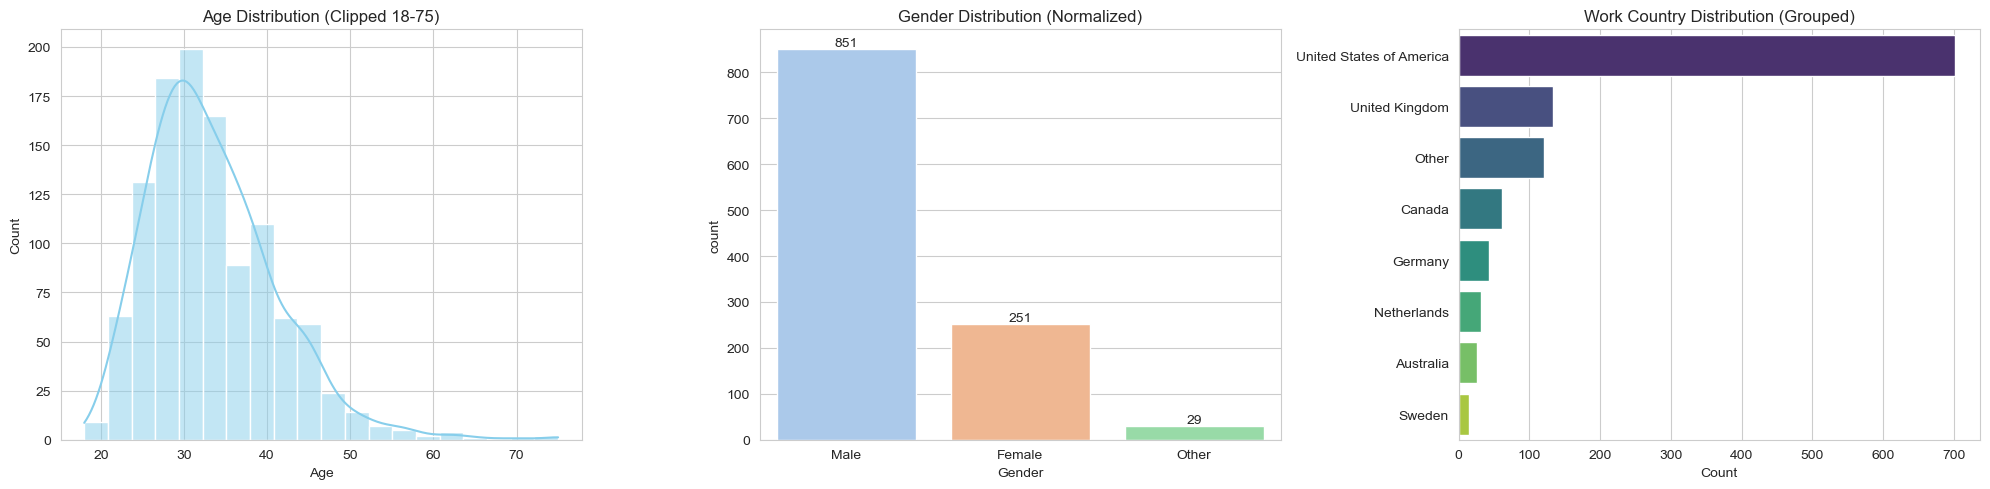

In [84]:
#Demographic EDA
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

#Age Distribution
sns.histplot(df_clean['age'], bins=20, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Age Distribution (Clipped 18-75)')
axes[0].set_xlabel('Age')

#Gender Distribution
sns.countplot(x='gender', data=df_clean, palette='pastel', order=['Male', 'Female', 'Other'], ax=axes[1])
axes[1].set_title('Gender Distribution (Normalized)')
axes[1].set_xlabel('Gender')
for container in axes[1].containers:
    axes[1].bar_label(container)

#Country Distribution
country_order = df_clean['country_work'].value_counts().index
sns.countplot(y='country_work', data=df_clean, palette='viridis', order=country_order, ax=axes[2])
axes[2].set_title('Work Country Distribution (Grouped)')
axes[2].set_xlabel('Count')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

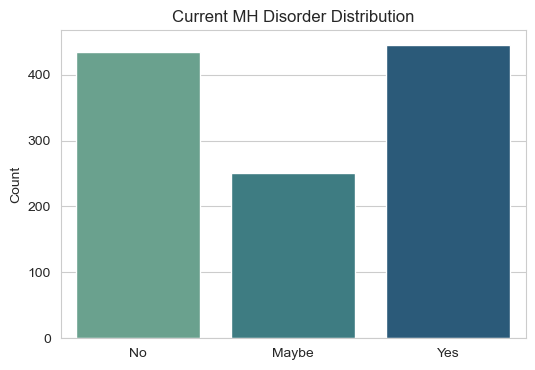

In [85]:
#Proxy Target Variable: Current Mental Health Disorder
plt.figure(figsize=(6, 4))
sns.countplot(x='curr_mh_disorder', data=df_clean, palette='crest', order=['No', 'Maybe', 'Yes'])
plt.title('Current MH Disorder Distribution')
plt.xlabel('')
plt.ylabel('Count')
plt.show()

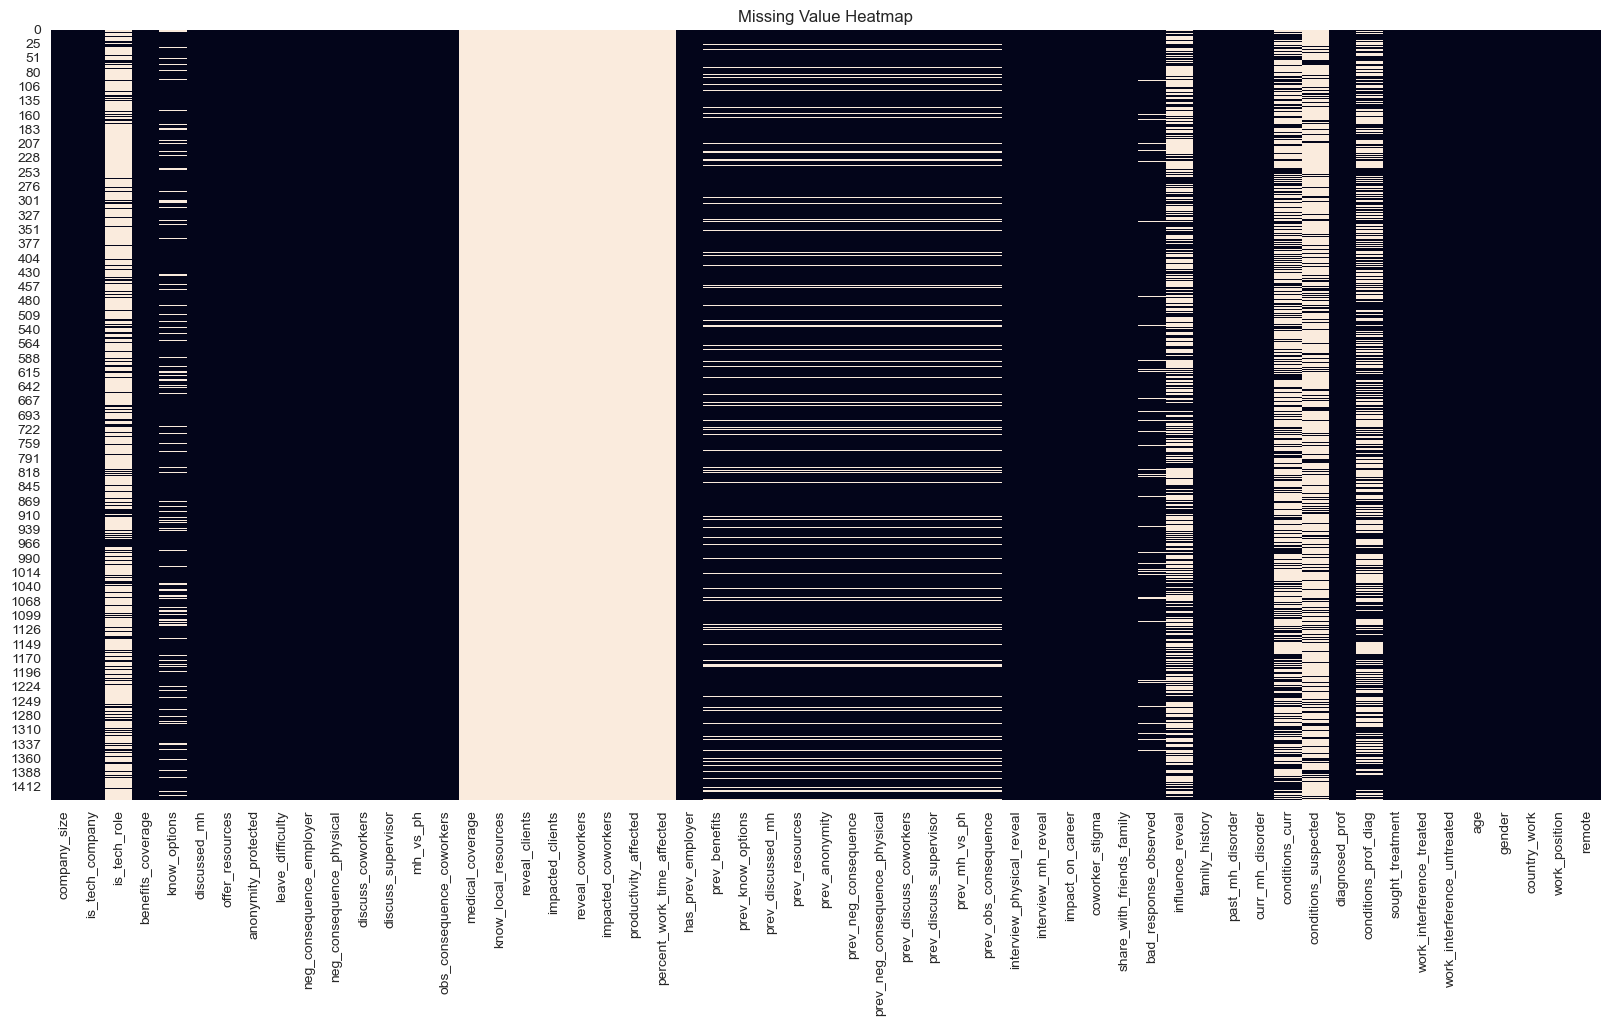

In [86]:
#Missing Value Overview 1
plt.figure(figsize=(20, 10))
sns.heatmap(df_clean.isna(), annot=False, cbar=False, vmin=0, vmax=1)
plt.title('Missing Value Heatmap')
plt.show()

In [87]:
#Missing Value Percentages
df_clean.isna().mean().sort_values(ascending=False)

reveal_coworkers                 1.000000
medical_coverage                 1.000000
percent_work_time_affected       1.000000
productivity_affected            1.000000
impacted_coworkers               1.000000
impacted_clients                 1.000000
reveal_clients                   1.000000
know_local_resources             1.000000
conditions_suspected             0.781609
is_tech_role                     0.780725
conditions_curr                  0.611848
influence_reveal                 0.556145
conditions_prof_diag             0.507515
know_options                     0.117595
prev_discussed_mh                0.113174
prev_resources                   0.113174
prev_benefits                    0.113174
prev_neg_consequence             0.113174
prev_neg_consequence_physical    0.113174
prev_discuss_coworkers           0.113174
prev_discuss_supervisor          0.113174
prev_mh_vs_ph                    0.113174
prev_obs_consequence             0.113174
prev_know_options                0

In [88]:
#Drop fully missing columns
df_clean.dropna(axis=1, how='all', inplace=True)
df_clean.shape

(1131, 49)

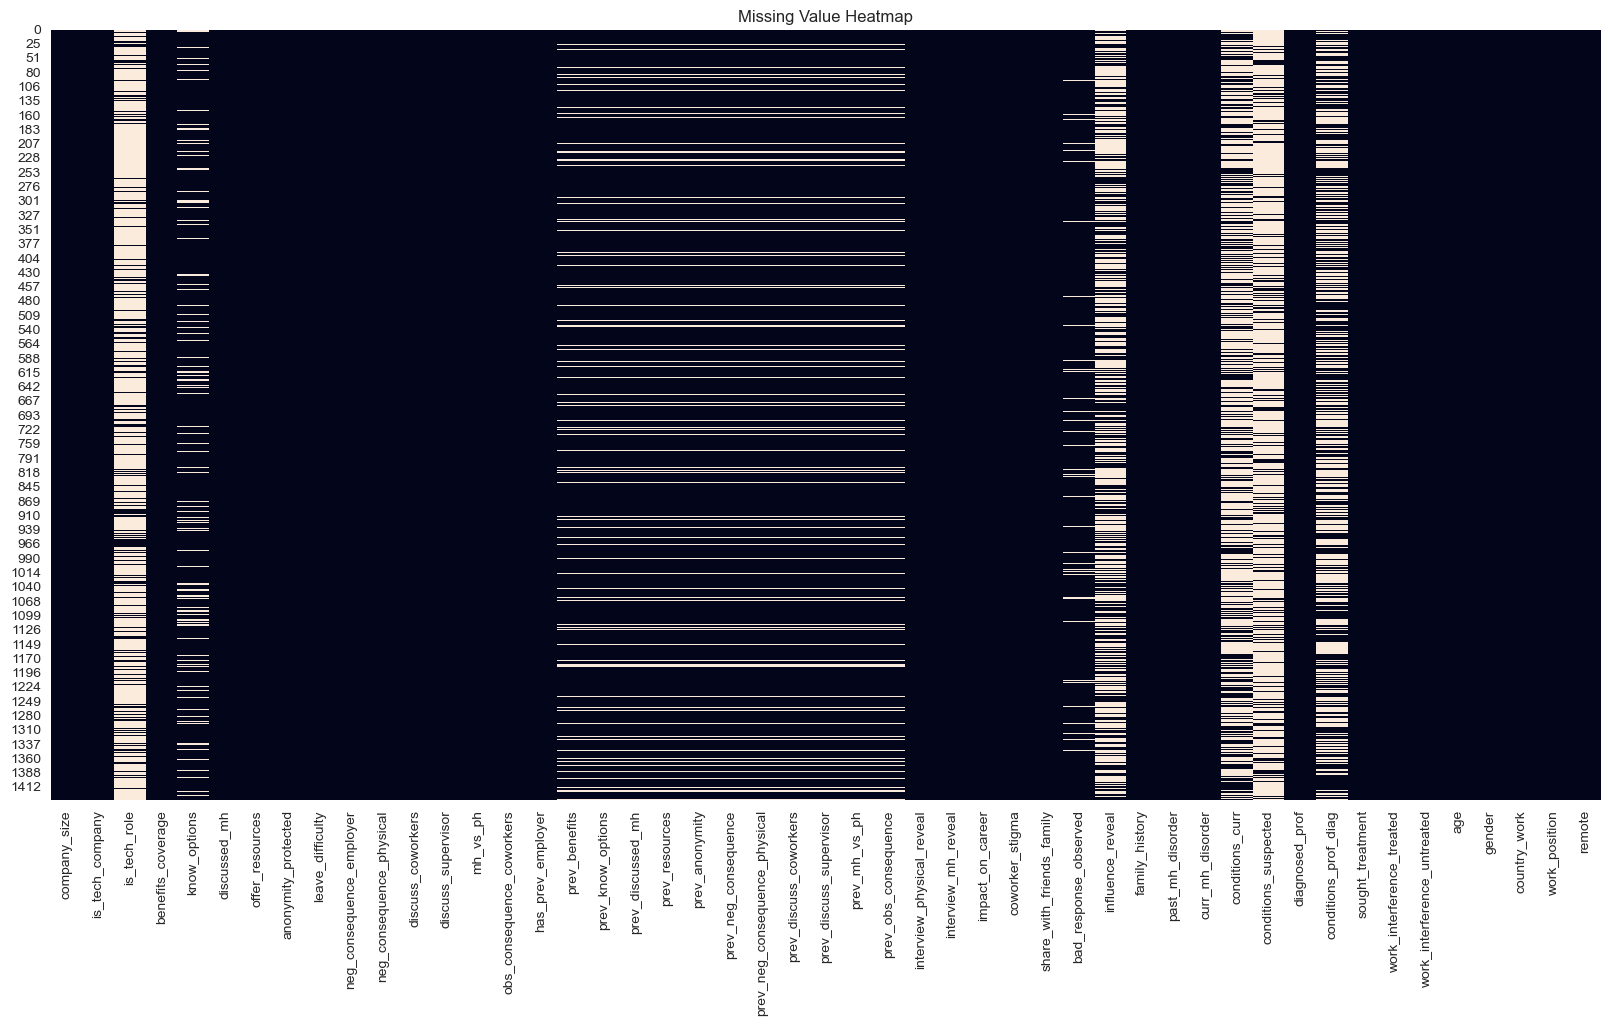

In [89]:
#Missing Value Overview 2
plt.figure(figsize=(20, 10))
sns.heatmap(df_clean.isna(), annot=False, cbar=False, vmin=0, vmax=1)
plt.title('Missing Value Heatmap')
plt.show()

<Figure size 2000x1000 with 0 Axes>

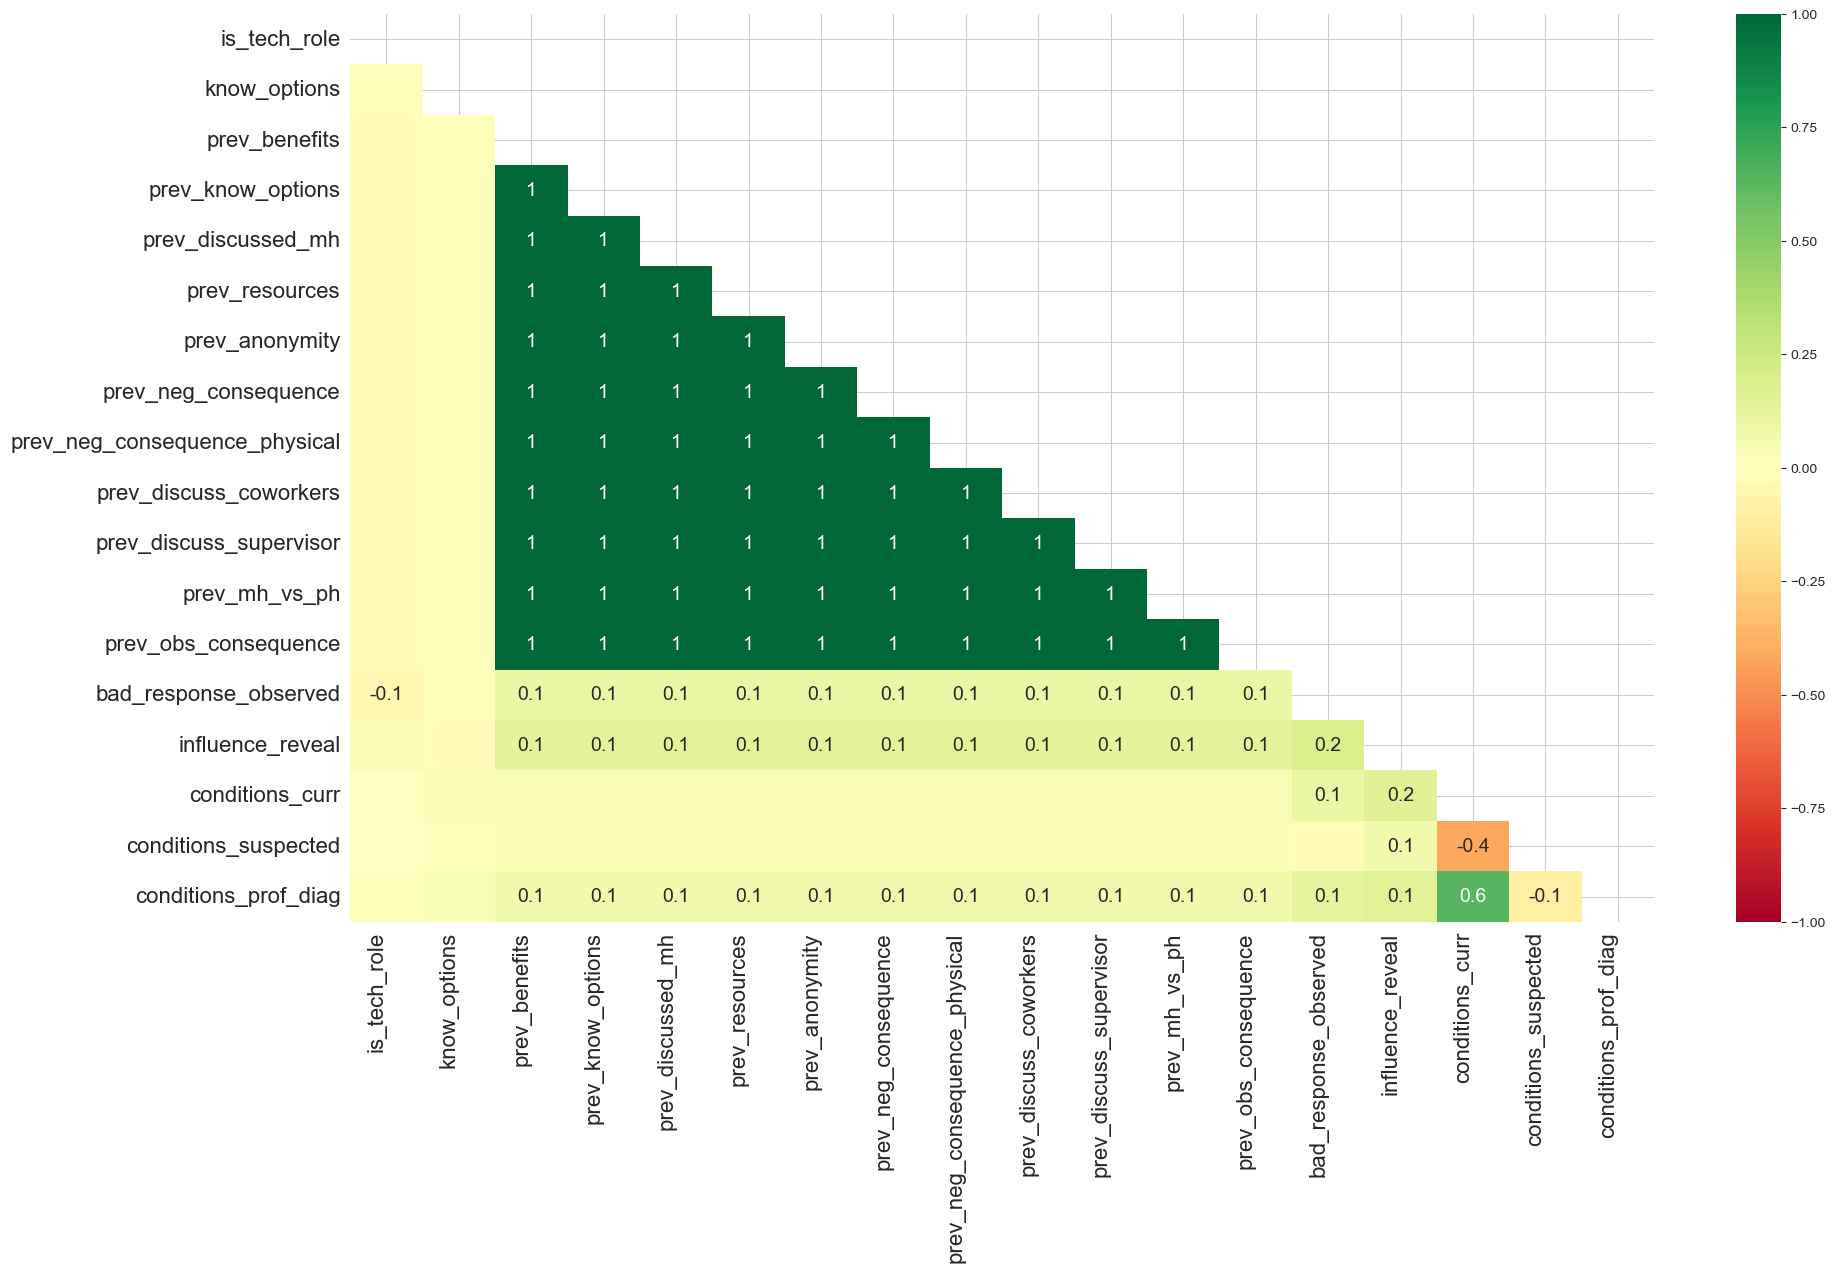

In [90]:
#Nullity Correlation Heatmap
plt.figure(figsize=(20, 10))
msno.heatmap(df_clean, cmap='RdYlGn')
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

<Axes: >

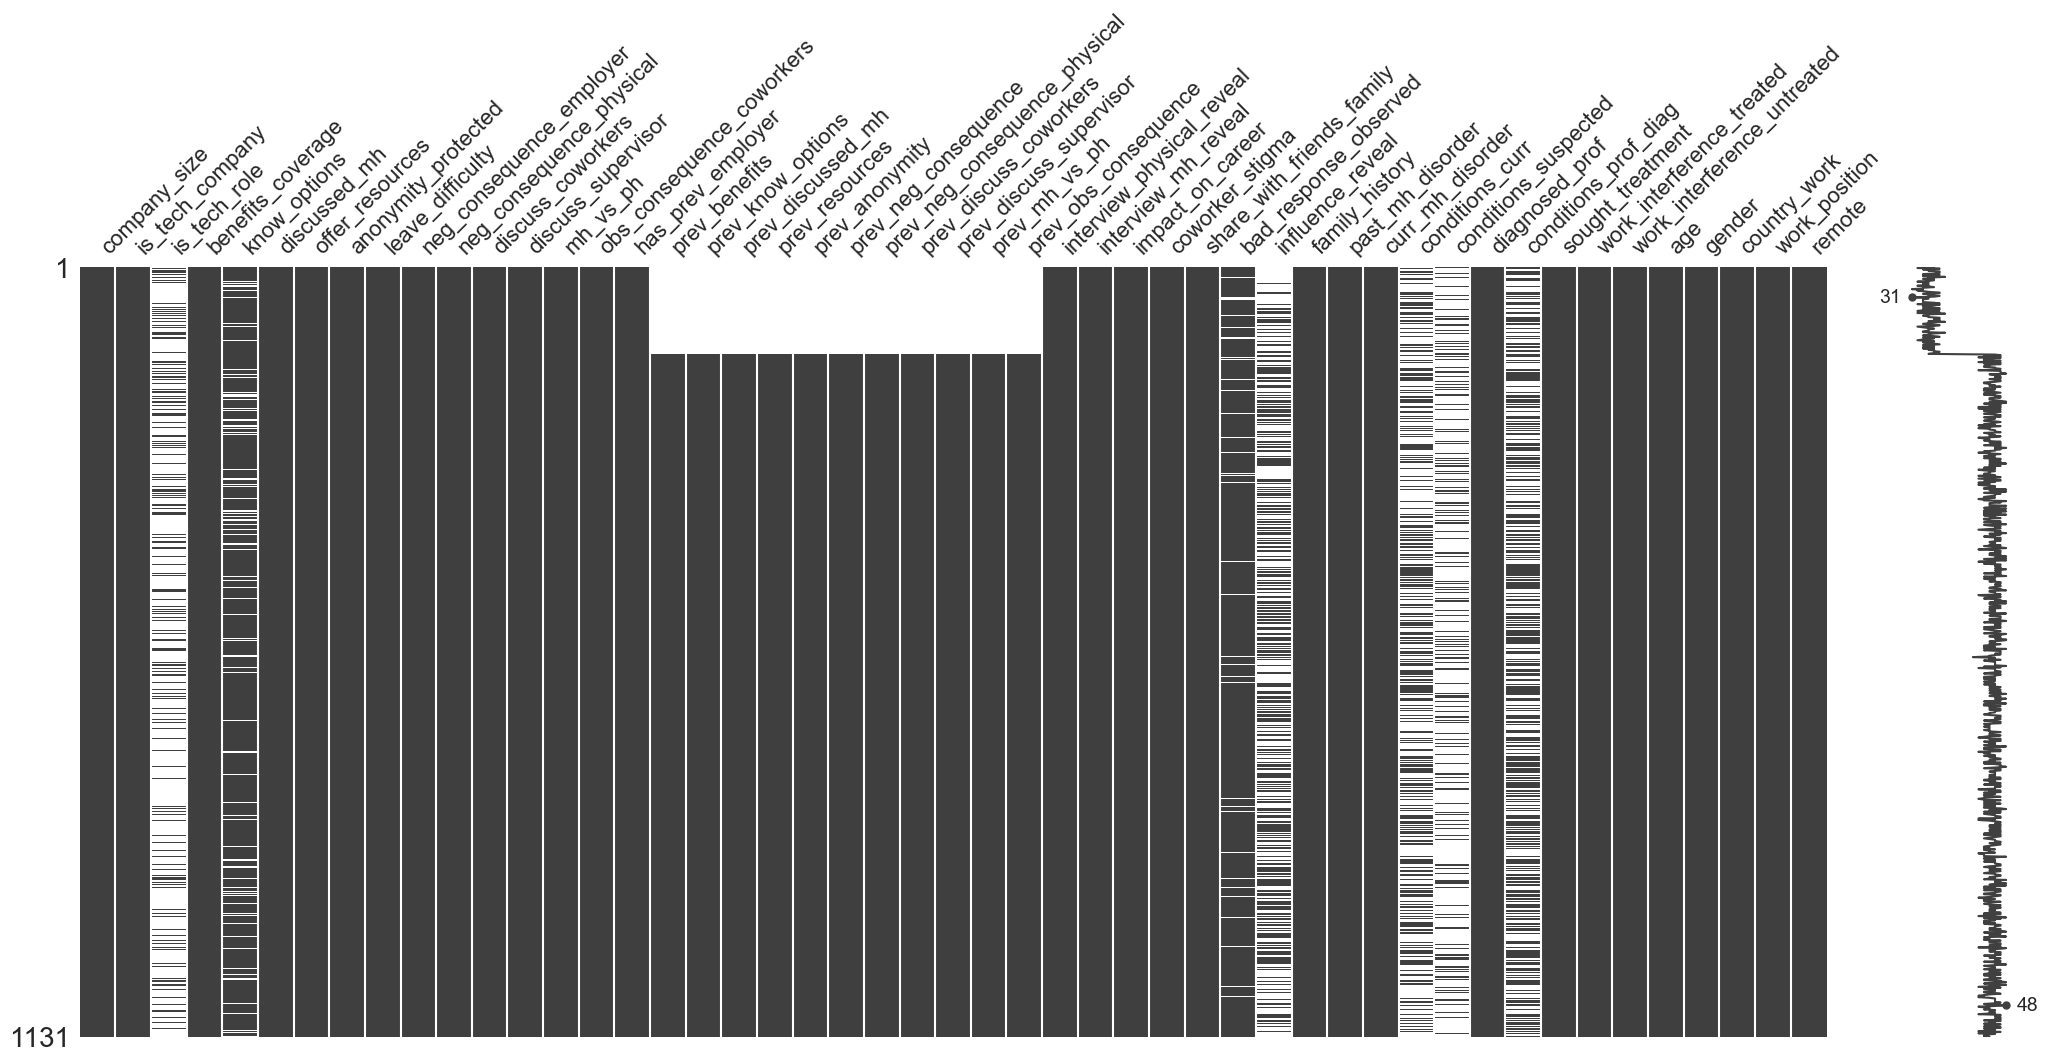

In [91]:
#Structural Missingness Testing
msno.matrix(df_clean.sort_values('has_prev_employer'))

<Axes: >

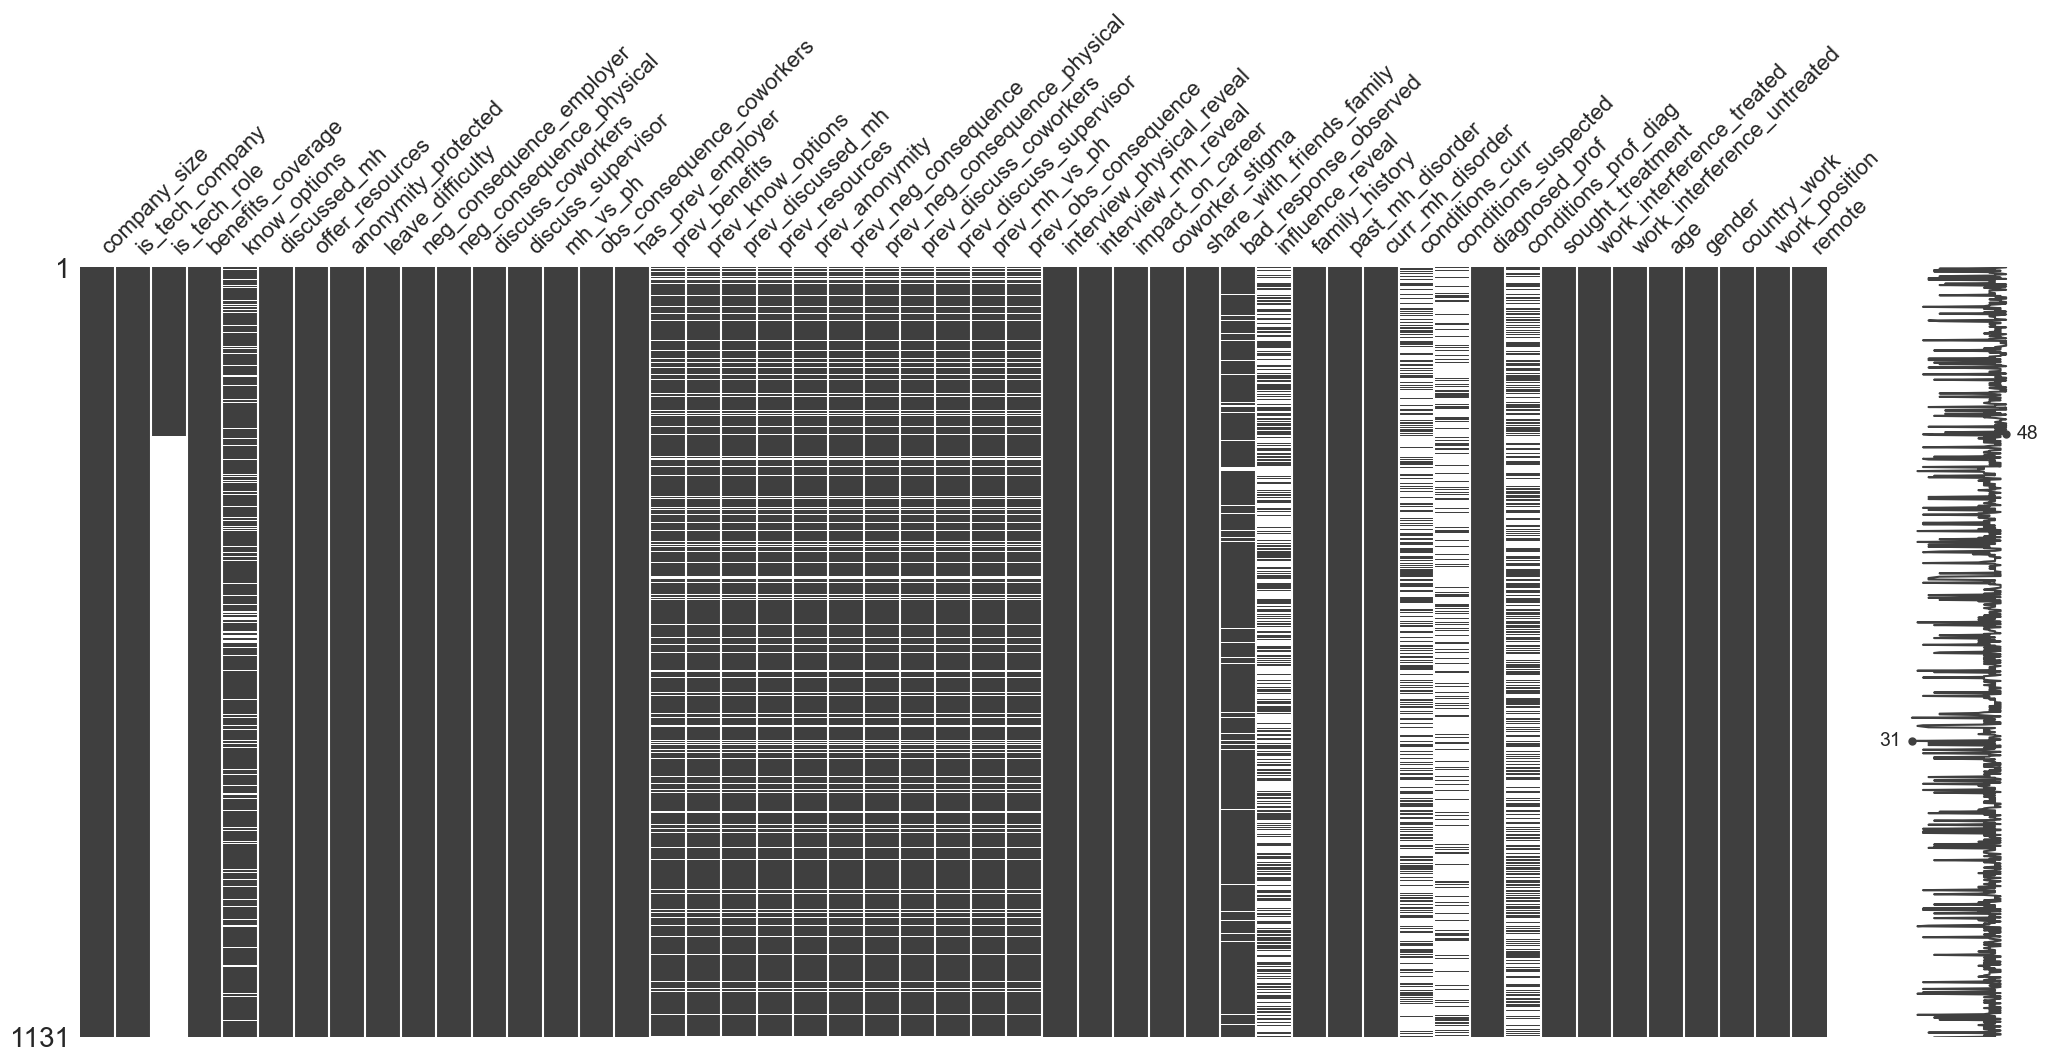

In [92]:
msno.matrix(df_clean.sort_values('is_tech_company'))

In [93]:
print(df_clean.groupby('is_tech_company')['is_tech_role'].apply(lambda x: x.isnull().mean()))

is_tech_company
No     0.0
Yes    1.0
Name: is_tech_role, dtype: float64


<Axes: >

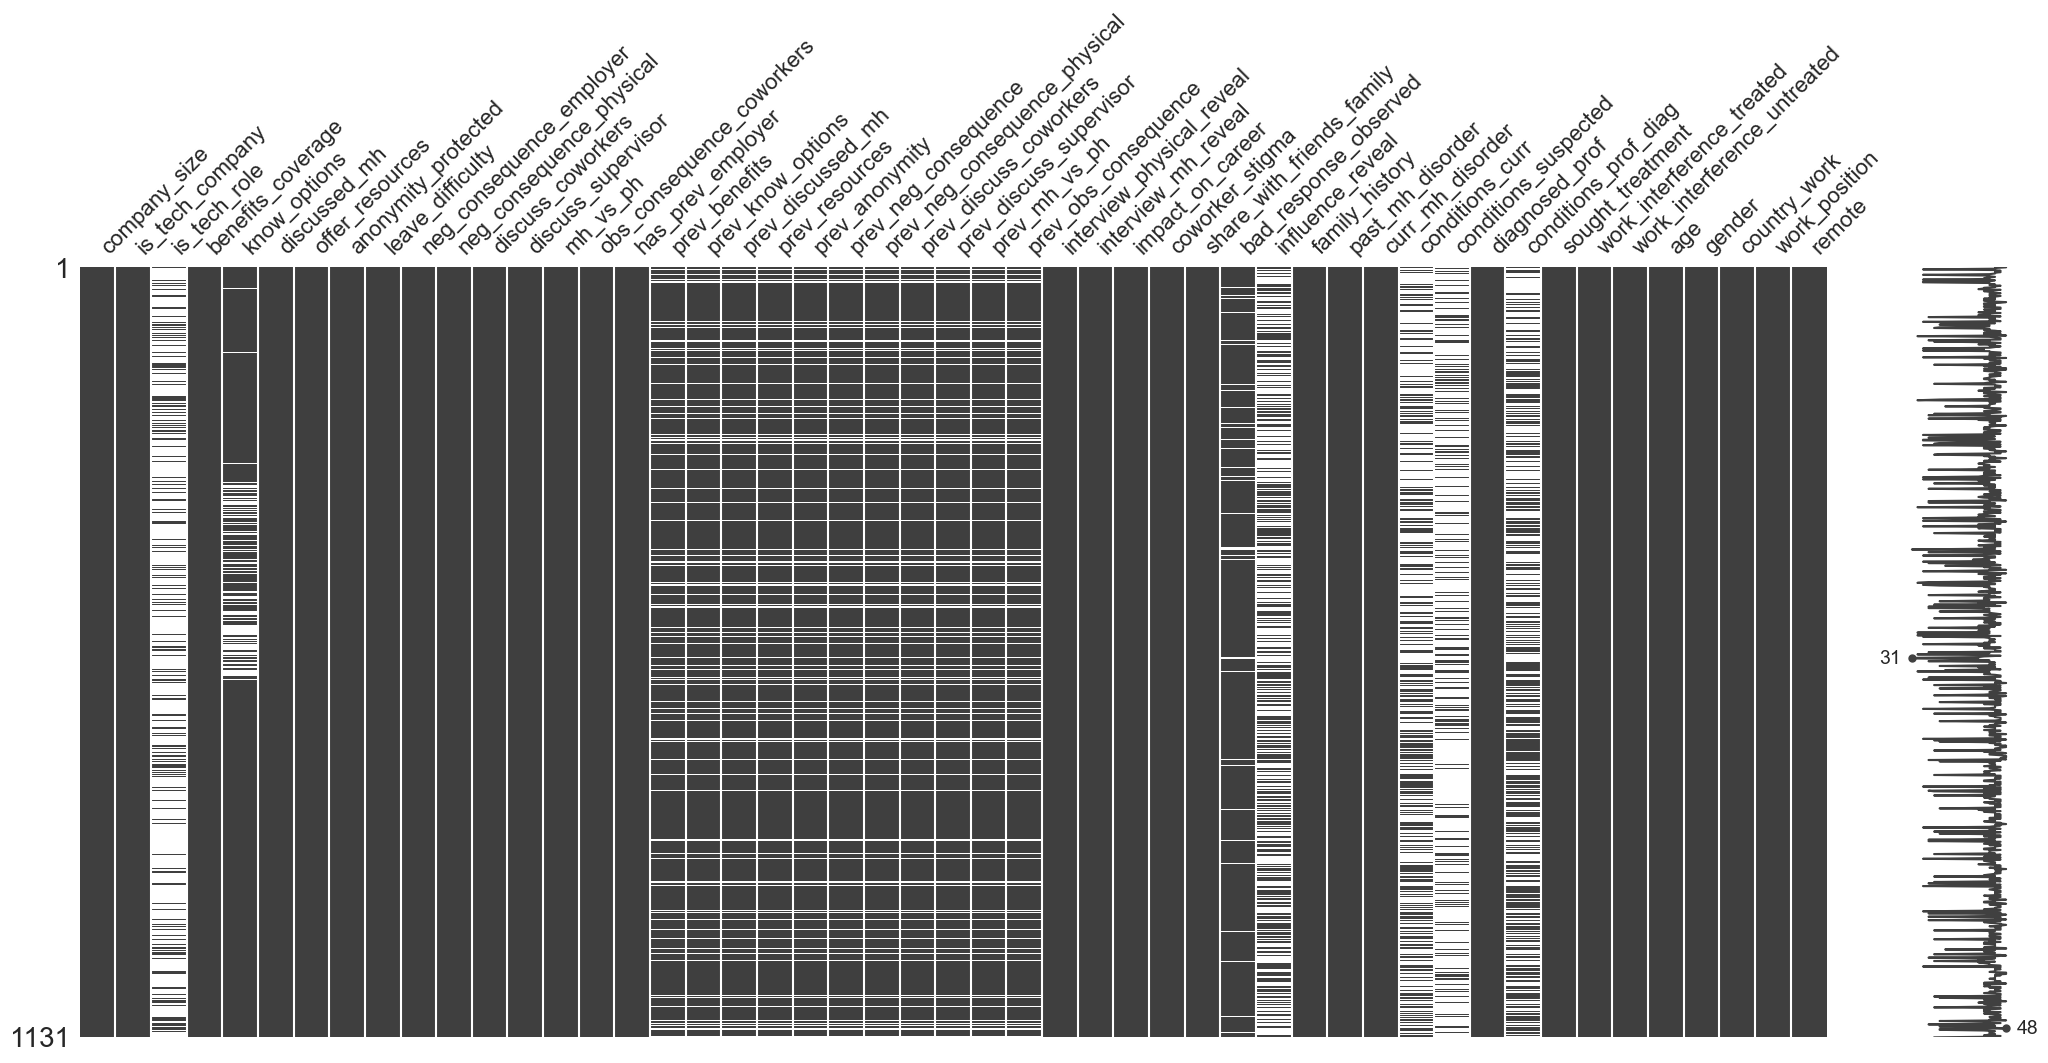

In [94]:
msno.matrix(df_clean.sort_values('benefits_coverage'))

In [95]:
print(df_clean.groupby('benefits_coverage')['know_options'].apply(lambda x: x.isnull().mean()))

benefits_coverage
I don't know                       0.018987
No                                 0.342857
Not eligible for coverage / N/A    0.679012
Yes                                0.000000
Name: know_options, dtype: float64


<Axes: >

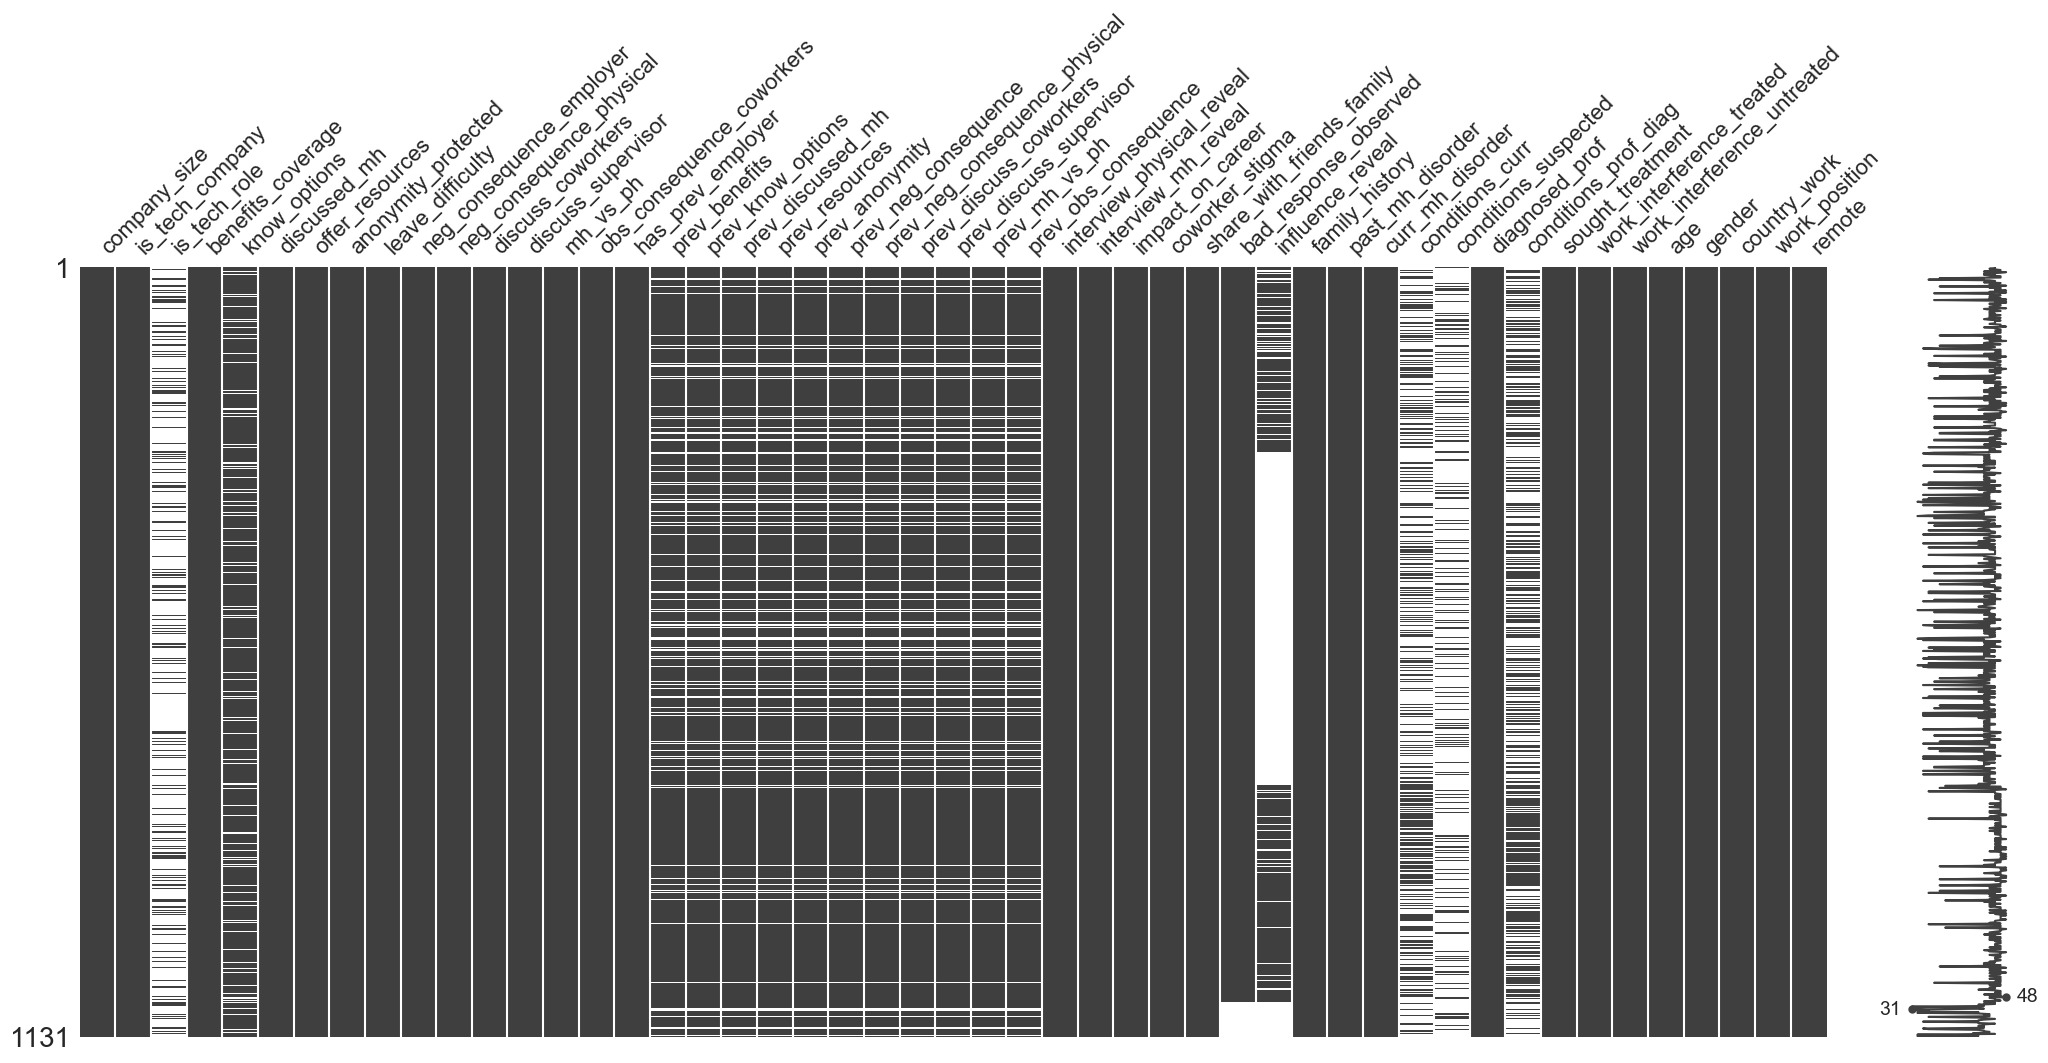

In [96]:
msno.matrix(df_clean.sort_values('bad_response_observed'))

In [97]:
print(df_clean.groupby('bad_response_observed')['influence_reveal'].apply(lambda x: x.isnull().mean()))

bad_response_observed
Maybe/Not sure        0.205882
No                    1.000000
Yes, I experienced    0.171875
Yes, I observed       0.062500
Name: influence_reveal, dtype: float64


<Axes: >

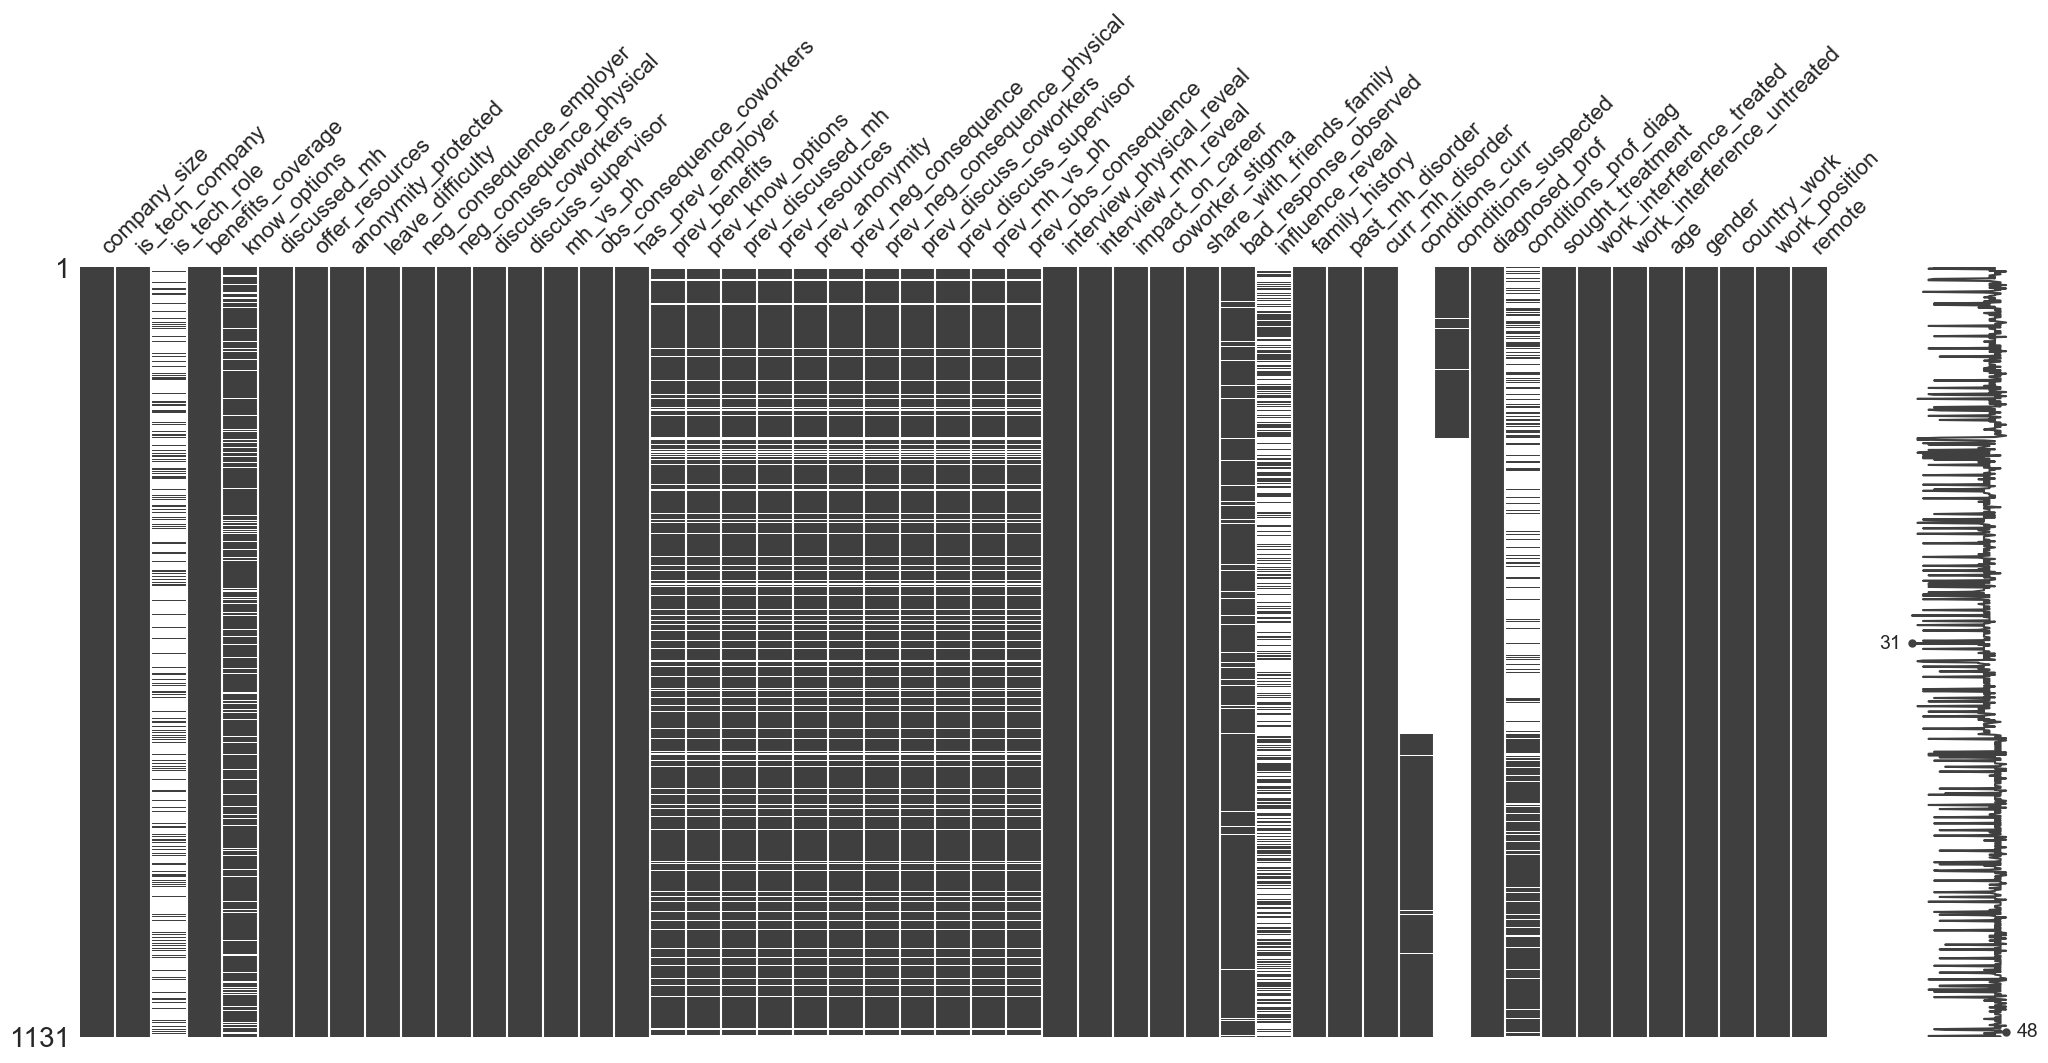

In [98]:
msno.matrix(df_clean.sort_values('curr_mh_disorder'))

In [99]:
print(df_clean.groupby('curr_mh_disorder')['conditions_curr'].apply(lambda x: x.isnull().mean()))

curr_mh_disorder
Maybe    1.000000
No       1.000000
Yes      0.013483
Name: conditions_curr, dtype: float64


In [100]:
print(df_clean.groupby('curr_mh_disorder')['conditions_suspected'].apply(lambda x: x.isnull().mean()))

curr_mh_disorder
Maybe    0.015936
No       1.000000
Yes      1.000000
Name: conditions_suspected, dtype: float64


<Axes: >

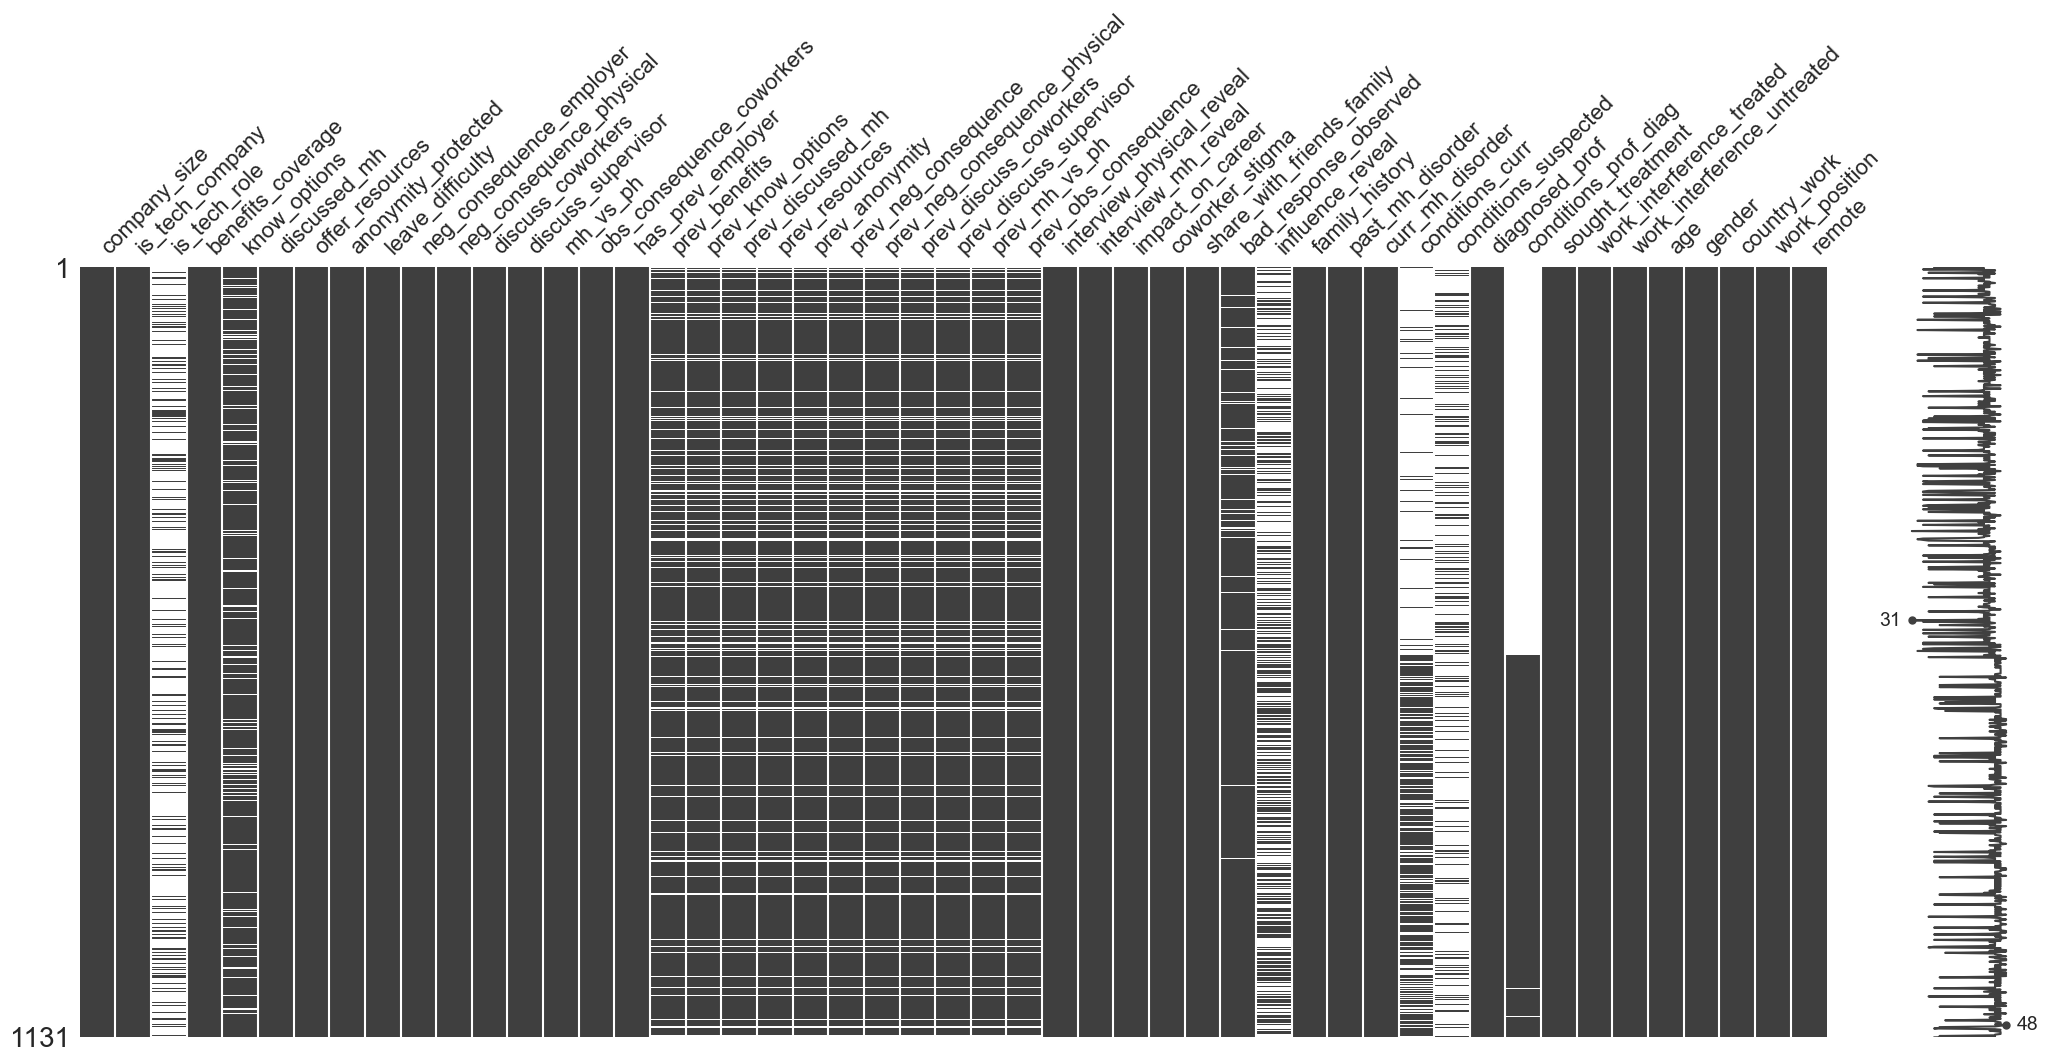

In [101]:
msno.matrix(df_clean.sort_values('diagnosed_prof'))

In [102]:
print(df_clean.groupby('diagnosed_prof')['conditions_prof_diag'].apply(lambda x: x.isnull().mean()))

diagnosed_prof
No     1.00000
Yes    0.00713
Name: conditions_prof_diag, dtype: float64


In [103]:
df_clean.to_csv('../data/processed/df_struct.csv', index=False)

### 2.2 Data Preprocessing
#### 2.2.1 Missing Value Strategy
Treatment constitutes a strategic balance of information retention and analytical requirements:
1.  **Structural Imputation:** Missing values resulting from skip-logic (e.g., questions not asked based on previous answers) are encoded as `-1` or `"N/A"` to preserve the behavioral signal of non-applicability.
2.  **Non-structural Imputation:** Remaining categorical gaps are labeled `"Unknown"`, preserving uncertainty as a valuable behavioral indicator rather than imputing with mode.

In [104]:
#Structural Imputation Function

def impute_struct(df, trigger_col, target_cols, trigger_vals_for_skip, fill_val='N/A'):

    if not isinstance(trigger_vals_for_skip, list):
        trigger_vals_for_skip = [trigger_vals_for_skip]
        
    mask_skip = df[trigger_col].isin(trigger_vals_for_skip)
    
    for target in target_cols:
        if target in df.columns:
            if df[target].dtype.name == 'category' and fill_val not in df[target].cat.categories:
                df[target] = df[target].cat.add_categories(fill_val)
            df.loc[mask_skip, target] = df.loc[mask_skip, target].fillna(fill_val)
 
    return df

In [105]:
#Prev employers block
prev_targets = [col for col in df_clean.columns if 'prev_' in col and col != 'has_prev_employer']
df_clean = impute_struct(df_clean, 'has_prev_employer', prev_targets, ['No'])

In [106]:
#MH conditions block
df_clean = impute_struct(df_clean, 'curr_mh_disorder', ['conditions_curr'], ['No', 'Maybe'])
df_clean = impute_struct(df_clean, 'curr_mh_disorder', ['conditions_suspected'], ['No', 'Yes'])
df_clean = impute_struct(df_clean, 'diagnosed_prof', ['conditions_prof_diag'], ['No'])

In [107]:
#Bad response
df_clean = impute_struct(df_clean, 'bad_response_observed', ['influence_reveal'], ['No'])

In [108]:
#Benefit coverage
df_clean = impute_struct(df_clean, 'benefits_coverage', ['know_options'], ['No', 'Not eligible for coverage / N/A'])

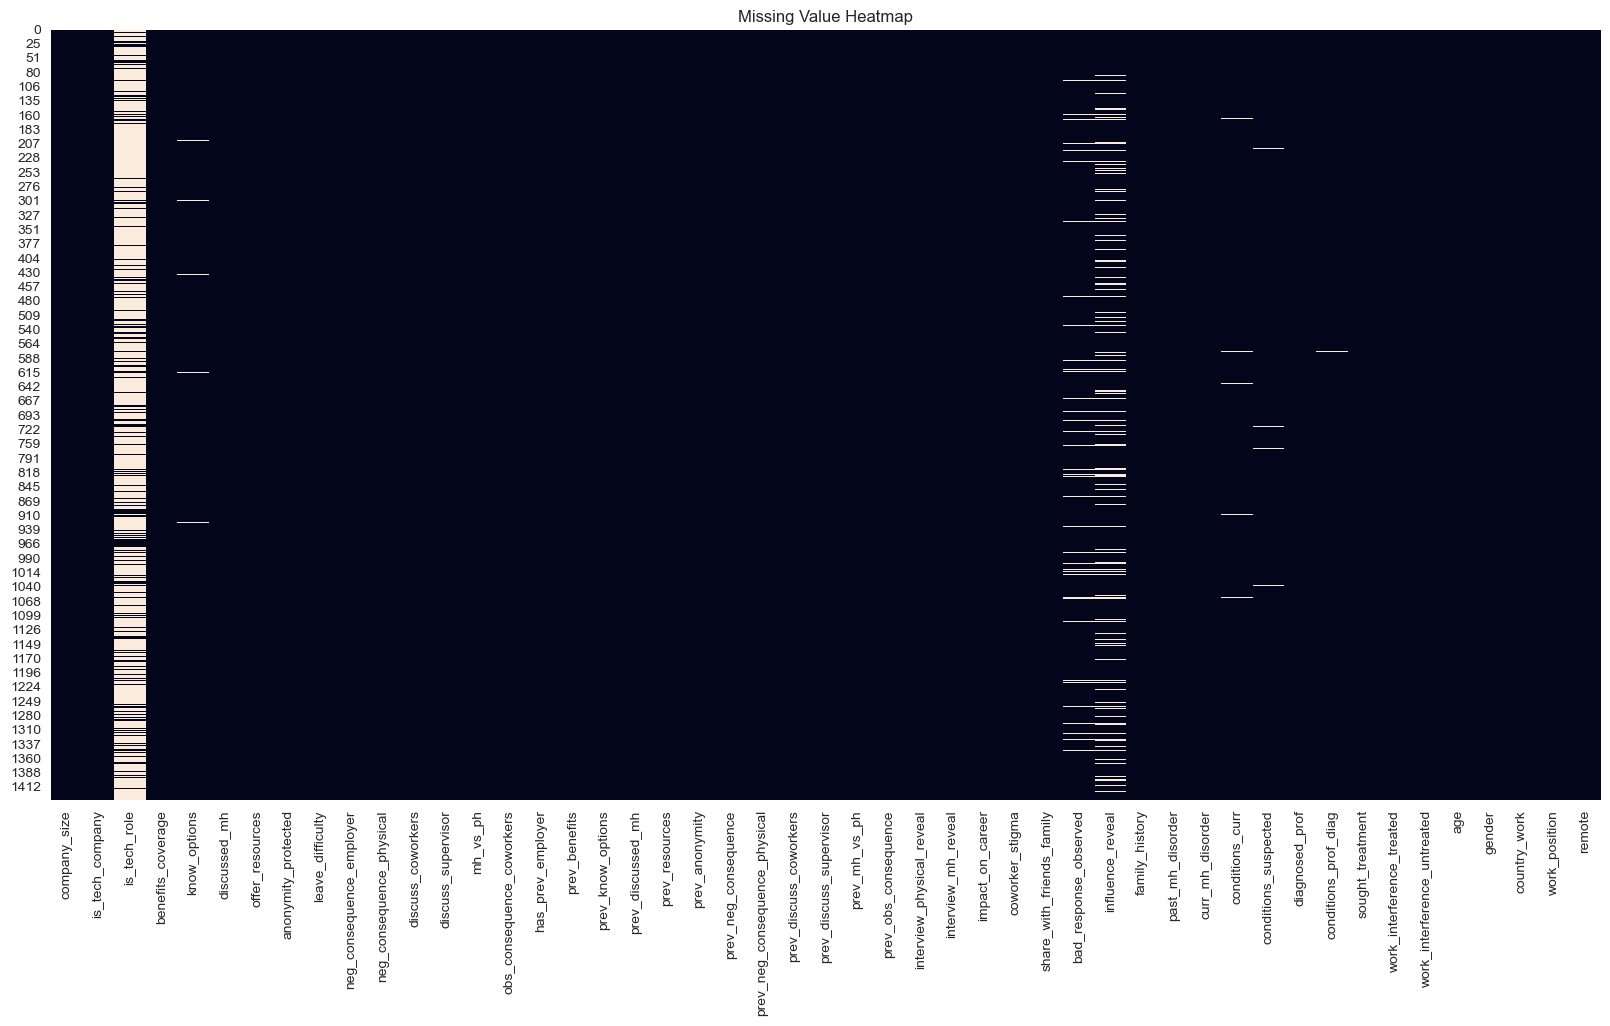

In [109]:
#Missing Value Overview 3
plt.figure(figsize=(20, 10))
sns.heatmap(df_clean.isna(), annot=False, cbar=False, vmin=0, vmax=1)
plt.title('Missing Value Heatmap')
plt.show()

In [110]:
#Drop tech role column due to lack of variance and previous scope focus
df_clean = df_clean.drop(columns=['is_tech_role'])

In [111]:
#Non-structural Imputation
cols = df_clean.columns[df_clean.isna().any()].tolist()
threshold = 0.01

for col in cols:
    missing = df_clean[col].isna().mean()
    if missing < threshold:
        print(col)
        df_clean = df_clean.dropna(subset=[col])
    else:
        if 'Unknown' not in df_clean[col].cat.categories:
            df_clean[col] = df_clean[col].cat.add_categories('Unknown')
            df_clean[col] = df_clean[col].fillna('Unknown')

know_options
conditions_curr
conditions_suspected
conditions_prof_diag


In [112]:
#Null-value check
df_clean.isna().sum().sum()

0

In [113]:
#Merging diagnoses column values to reduce dimensionality
def merge_diagnoses(row):
    conditions = set()
    for c in ['conditions_curr', 'conditions_prof_diag', 'conditions_suspected']:
        val = str(row.get(c, ''))
        if val not in ['N/A', 'Unknown', 'nan', 'None', '0']:
            conditions.update([x.strip() for x in val.split('|') if x.strip()])

    return '|'.join(sorted(conditions)) if conditions else 'N/A'

In [114]:
df_clean['conditions'] = df_clean.apply(merge_diagnoses, axis=1)
cols = ['conditions_curr', 'conditions_suspected', 'conditions_prof_diag']
df_clean = df_clean.drop(columns=cols)

In [115]:
#Unique values for multi-label columns function
def get_unique_items(df, col):
    unique_items = set()
    # Drop nulls/N/A for inspection
    raw_values = df[df[col] != 'N/A'][col].dropna()

    for row in raw_values:
        # Split by separator (assuming previous step used '|')
        # Note: work_position in raw data often uses no separator or '|',
        # but the standard 2016 data usually comes pre-split or distinct.
        # We'll assume the raw strings might need splitting.
        items = str(row).split('|')
        for item in items:
            unique_items.add(item.strip())

    return sorted(list(unique_items))

print('work_position')
print(get_unique_items(df_clean, 'work_position'))
print("\nconditions")
print(get_unique_items(df_clean, 'conditions'))

work_position
['Back-end Developer', 'Designer', 'Dev Evangelist/Advocate', 'DevOps/SysAdmin', 'Executive Leadership', 'Front-end Developer', 'HR', 'One-person shop', 'Other', 'Sales', 'Supervisor/Team Lead', 'Support']

conditions
['ADD (w/o Hyperactivity)', 'Addictive Disorder', 'Anxiety Disorder (Generalized, Social, Phobia, etc)', 'Asperger Syndrome', "Asperger's", 'Asperges', 'Attention Deficit Disorder', 'Attention Deficit Hyperactivity Disorder', 'Autism', "Autism (Asperger's)", 'Autism - while not a "mental illness", still greatly affects how I handle anxiety', 'Autism Spectrum Disorder', 'Autism spectrum disorder', 'Depersonalisation', 'Dissociative Disorder', 'Eating Disorder (Anorexia, Bulimia, etc)', 'Gender Identity Disorder', 'Mood Disorder (Depression, Bipolar Disorder, etc)', 'Obsessive-Compulsive Disorder', 'PDD-NOS (see above)', 'PTSD (undiagnosed)', 'Personality Disorder (Borderline, Antisocial, Paranoid, etc)', 'Pervasive Developmental Disorder (Not Otherwise Specif

In [116]:
#Multi-label handling
def multilabel(df, target, map, prefix):
    for cat, keywords in map.items():
        pattern = '|'.join([re.escape(k) for k in keywords])
        new_col = f"{prefix}_{cat}"

        df[new_col] = 'No'
        mask_match = df[target].astype(str).str.contains(pattern, case=False, na=False)
        df.loc[mask_match, new_col] = 'Yes'
        df[new_col] = df[new_col].astype('category')
    return df

In [117]:
#Collapsing work positions into groups
work_map = {
    'dev': ['Back-end', 'Front-end', 'One-person'],
    'design': ['Designer', 'One-person'],
    'support': ['Evangelist', 'HR', 'One-person', 'Sales', 'Support'],
    'ops': ['DevOps', 'One-person'],
    'lead': ['Executive', 'One-person', 'Supervisor'],
    'other': ['Other']
}

df_clean = multilabel(df_clean, 'work_position', work_map, 'role')

In [118]:
#Collapsing MH conditions by category
condition_map = {
    'neurodevelopmental': ['ADD', 'Attention Deficit', 'ADHD', 'Autism', 'Asperger', 'Asperges', 'ASD', 'Autism Spectrum', 'PDD-NOS', 'Pervasive Developmental'],
    'anxiety': ['Anxiety', 'Phobia', 'Social', 'Generalized', 'Obsessive-Compulsive', 'OCD'],
    'depressive': ['Mood Disorder', 'Depression', 'Bipolar', 'Manic', 'Seasonal Affective', 'post-partum', 'postpartum'],
    'trauma': ['PTSD', 'Post-traumatic', 'Posttraumatic', 'Trauma', 'Stress Response'],
    'personality_and_psychotic': ['Personality Disorder', 'Borderline', 'Antisocial', 'Paranoid', 'Schizotypal', 'Psychotic Disorder', 'Schizophrenia', 'Schizoaffective', 'Dissociative', 'Depersonalisation', 'Depersonalization', 'Depersonalisation'],
    'addictive': ['Substance Use', 'Addictive', 'Sexual addiction'],
    'other': ['Eating Disorder', 'Anorexia', 'Bulimia', 'Sleeping Disorder', 'Suicidal Ideation', 'Tinnitus', 'Traumatic Brain Injury', 'Transgender', 'Gender Identity Disorder']
}

df_clean = multilabel(df_clean, 'conditions', condition_map, 'condition')

In [119]:
#Dropping original multi-label columns
cols = ['work_position', 'conditions']
df_clean = df_clean.drop(columns=cols)

In [120]:
#Dataset categorical (mixed) version
df_cat = df_clean.copy()

#### 2.2.2 Feature Engineering and Encoding
* **Ordinal Variables:** Encoded numerically (e.g., $0 < 1 < 2$) to preserve rank (e.g., "No" < "Maybe" < "Yes").
* **Nominal Variables:** Kept categorical for the **K-Prototypes** algorithm, but One-Hot Encoded specifically for **FAMD** and **Mutual Information** analysis.
* **Age:** Standardized using Min-Max scaling after capping outliers ($<18$ or $>75$) to ensure equidistance in the distance matrix.

In [121]:
#Scaling
scaler = MinMaxScaler()
df_cat['age'] = scaler.fit_transform(df_cat[['age']])

In [122]:
#Column values
for col in df_cat.columns:
    print(f"{col}: {df_cat[col].unique()}\n")

company_size: ['26-100', '6-25', 'More than 1000', '100-500', '500-1000', '1-5']
Categories (6, object): ['1-5', '100-500', '26-100', '500-1000', '6-25', 'More than 1000']

is_tech_company: ['Yes', 'No']
Categories (2, object): ['No', 'Yes']

benefits_coverage: ['Not eligible for coverage / N/A', 'No', 'Yes', 'I don't know']
Categories (4, object): ['I don't know', 'No', 'Not eligible for coverage / N/A', 'Yes']

know_options: ['N/A', 'Yes', 'I am not sure', 'No']
Categories (4, object): ['I am not sure', 'No', 'Yes', 'N/A']

discussed_mh: ['No', 'Yes', 'I don't know']
Categories (3, object): ['I don't know', 'No', 'Yes']

offer_resources: ['No', 'Yes', 'I don't know']
Categories (3, object): ['I don't know', 'No', 'Yes']

anonymity_protected: ['I don't know', 'Yes', 'No']
Categories (3, object): ['I don't know', 'No', 'Yes']

leave_difficulty: ['Very easy', 'Somewhat easy', 'Neither easy nor difficult', 'Very difficult', 'Somewhat difficult', 'I don't know']
Categories (6, object): ['

In [123]:
#Value standardization across dataset
std_map = {
    'universal': {
        'Not applicable to me': 'N/A',
        'Not applicable to me (I do not have a mental illness)': 'N/A',

        #In the case of the two values below, non-applicability is semantically identical to "No" for the corresponding questions
        'Not eligible for coverage / N/A': 'No',
        'N/A (not currently aware)': 'No',

        'I am not sure': "Unknown",
        "I don't know": 'Unknown',
    },
    'sentiment': {
        **{
            k: 'Yes' for k in [
                'Yes, they all did',
                'Yes, I was aware of all of them',
                'Yes, all of them',
                'Yes, at all of my previous employers',
                'Yes, always',
                'Yes, I think it would',
                'Yes, it has',
                'Yes, they do',
                'Yes, I think they would',
                'Yes, I experienced',
                'Yes, I observed',
            ]
        },

        **{
            k: 'Maybe' for k in [
                'Some did',
                'Some of them',
                'Some of my previous employers',
                'I was aware of some',
                'Maybe/Not sure'
            ]
        },

        **{
            k: 'No' for k in [
                'None did',
                'No, none did',
                'None of them',
                'No, at none of my previous employers',
                'No, I only became aware later',
                "No, I don't think it would",
                'No, it has not',
                "No, I don't think they would",
                'No, they do not',
            ]
        }
    }
}

for col in df_cat.select_dtypes(include=['category', 'object']):
    df_cat[col] = df_cat[col].map(std_map['universal']).fillna(df_cat[col])
    df_cat[col] = df_cat[col].map(std_map['sentiment']).fillna(df_cat[col])
df_cat['prev_anonymity'] = df_cat['prev_anonymity'].replace('Sometimes', 'Maybe')

In [124]:
#Updated column values
for col in df_cat.columns:
    print(f"{col}: {df_cat[col].unique()}\n")

company_size: ['26-100' '6-25' 'More than 1000' '100-500' '500-1000' '1-5']

is_tech_company: ['Yes' 'No']

benefits_coverage: ['No' 'Yes' 'Unknown']

know_options: ['N/A' 'Yes' 'Unknown' 'No']

discussed_mh: ['No' 'Yes' 'Unknown']

offer_resources: ['No' 'Yes' 'Unknown']

anonymity_protected: ['Unknown' 'Yes' 'No']

leave_difficulty: ['Very easy' 'Somewhat easy' 'Neither easy nor difficult' 'Very difficult'
 'Somewhat difficult' 'Unknown']

neg_consequence_employer: ['No' 'Maybe' 'Yes']

neg_consequence_physical: ['No' 'Maybe' 'Yes']

discuss_coworkers: ['Maybe' 'Yes' 'No']

discuss_supervisor: ['Yes' 'Maybe' 'No']

mh_vs_ph: ['Unknown' 'Yes' 'No']

obs_consequence_coworkers: ['No' 'Yes']

has_prev_employer: ['Yes' 'No']

prev_benefits: ['No' 'Yes' 'Unknown' 'Maybe' 'N/A']

prev_know_options: ['No' 'Maybe' 'Yes' 'N/A']

prev_discussed_mh: ['Unknown' 'No' 'Maybe' 'N/A' 'Yes']

prev_resources: ['No' 'Maybe' 'N/A' 'Yes']

prev_anonymity: ['Unknown' 'Yes' 'Maybe' 'No' 'N/A']

prev_neg_con

In [125]:
#Ordinal mapping
scales = {
    'size': ['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000'],
    'diff': ['Very easy', 'Somewhat easy', 'Neither easy nor difficult', 'Somewhat difficult', 'Very difficult'],
    'ternary': ['No', 'Maybe', 'Yes'],
    'freq': ['Never', 'Rarely', 'Sometimes', 'Often'],
    'remote': ['Never', 'Sometimes', 'Always'],
    'open': ['Not open at all', 'Somewhat not open', 'Neutral', 'Somewhat open', 'Very open'],
}

ordinal = {
    'size': ['company_size'],
    'diff': ['leave_difficulty'],
    'ternary': [col for col in df_cat.columns if df_cat[col].astype(str).str.contains('Maybe', na=False).any()],
    'freq': ['work_interference_treated', 'work_interference_untreated'],
    'remote': ['remote'],
    'open': ['share_with_friends_family'],
}

In [126]:
#Ordinal Encoding
for scale, cols in ordinal.items():
    valid = [c for c in cols if c in df_cat.columns]

    if valid:
        base = scales[scale]
        midpoint = base[len(base) // 2]
        df_cat[valid] = df_cat[valid].replace('Unknown', midpoint)

        encoder = OrdinalEncoder(categories=[base] * len(valid), dtype=int, handle_unknown='use_encoded_value', unknown_value=-1)
        df_cat[valid] = encoder.fit_transform(df_cat[valid].astype(str))

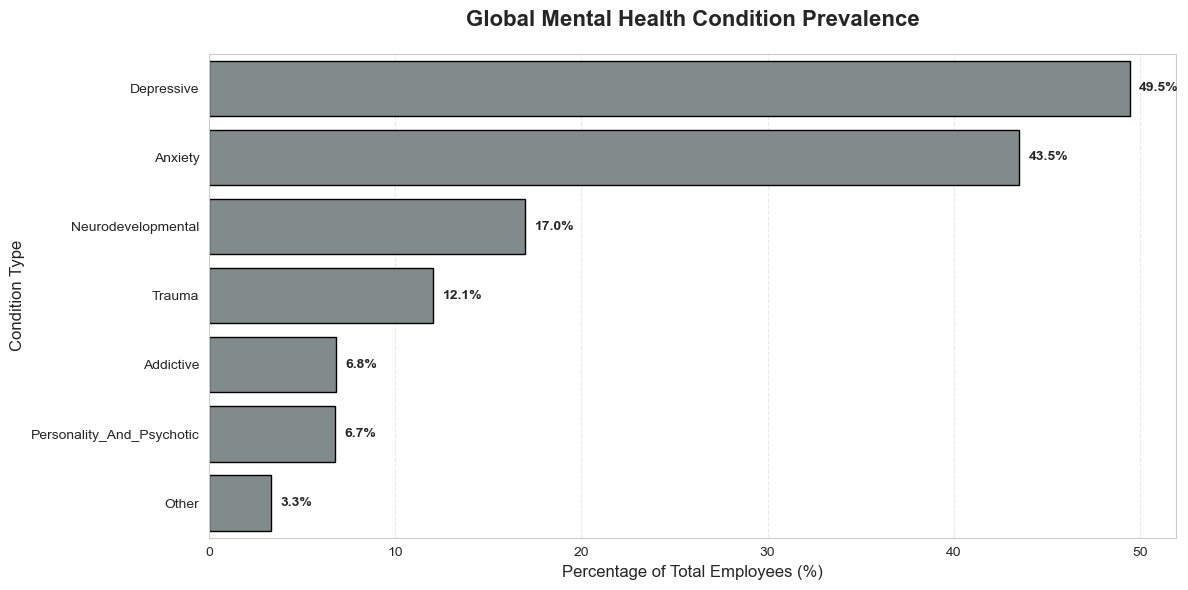

In [127]:
#Mental Health Condition Distribution

condition_cols = [c for c in df_clean.columns if 'condition_' in c.lower()]

global_conditions = (df_clean[condition_cols] == 'Yes').mean().sort_values(ascending=False) * 100
global_conditions.index = global_conditions.index.str.replace('condition_', '').str.title()

plt.figure(figsize=(12, 6))
sns.barplot(x=global_conditions.values, y=global_conditions.index, color='#7f8c8d', edgecolor='black')
plt.title('Global Mental Health Condition Prevalence', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Percentage of Total Employees (%)', fontsize=12)
plt.ylabel('Condition Type', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)
for i, val in enumerate(global_conditions.values):
    plt.text(val + 0.5, i, f'{val:.1f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [128]:
#Typecasting to category
df_mix = df_cat.copy()
cat_cols = df_mix.select_dtypes(include=['object']).columns
df_mix[cat_cols] = df_mix[cat_cols].astype('category')

In [129]:
#Fully numerical encoded
df_num = df_cat.copy()
cat_cols = df_num.select_dtypes(include=['object']).columns

#Nominal Encoding
onehot = OneHotEncoder(sparse_output=False, drop='first', dtype=int)
encoded = onehot.fit_transform(df_num[cat_cols])
encoded = pd.DataFrame(encoded, columns=onehot.get_feature_names_out(cat_cols), index=df_num.index)

df_num = pd.concat([df_num.drop(columns=cat_cols), encoded], axis=1)

In [130]:
#Mixed type DF
df_mix.head()

company_size is_tech_company benefits_coverage know_options discussed_mh  \
0             2             Yes                No          N/A           No   
1             1             Yes                No          Yes          Yes   
2             1             Yes                No          N/A           No   
4             1              No               Yes          Yes           No   
5             5             Yes               Yes      Unknown           No   

  offer_resources anonymity_protected  leave_difficulty  \
0              No             Unknown                 0   
1             Yes                 Yes                 1   
2              No             Unknown                 2   
4              No                  No                 2   
5             Yes                 Yes                 1   

   neg_consequence_employer  neg_consequence_physical  discuss_coworkers  \
0                         0                         0                  1   
1                         0                         0                  1   
2                         1                         0                  1   
4                         2                         1                  1   
5                         2                         2                  1   

   discuss_supervisor mh_vs_ph obs_consequence_coworkers has_prev_employer  \
0                   2  Unknown                        No               Yes   
1                   2      Yes                        No               Yes   
2                   1  Unknown                        No               Yes   
4                   0       No                        No               Yes   
5                   2       No                       Yes               Yes   

   prev_benefits  prev_know_options  prev_discussed_mh  prev_resources  \
0              0                  0                  1               0   
1              2                  1                  0               1   
2              0                  0                  0               1   
4              1                  0                  1               0   
5              0                  2                  0               0   

   prev_anonymity  prev_neg_consequence  prev_neg_consequence_physical  \
0               1                     1                              0   
1               2                     0                              0   
2               1                     1                              1   
4               1                     1                              1   
5               1                     2                              1   

   prev_discuss_coworkers  prev_discuss_supervisor  prev_mh_vs_ph  \
0                       1                        1              1   
1                       0                        1              1   
2                       1                        1              1   
4                       0                        1              1   
5                       0                        0              0   

   prev_obs_consequence  interview_physical_reveal  interview_mh_reveal  \
0                     0                          1                    1   
1                     0                          1                    0   
2                     1                          2                    2   
4                     1                          1                    0   
5                     1                          2                    1   

   impact_on_career  coworker_stigma  share_with_friends_family  \
0                 1                0                          3   
1                 0                0                          3   
2                 1                1                          3   
4                 2                1                          3   
5                 2                1                          3   

   bad_response_observed  influence_reveal family_history  past_mh_disorder  \
0        

In [131]:
#Numerical DF
df_num.head()

company_size  leave_difficulty  neg_consequence_employer  \
0             2                 0                         0   
1             1                 1                         0   
2             1                 2                         1   
4             1                 2                         2   
5             5                 1                         2   

   neg_consequence_physical  discuss_coworkers  discuss_supervisor  \
0                         0                  1                   2   
1                         0                  1                   2   
2                         0                  1                   1   
4                         1                  1                   0   
5                         2                  1                   2   

   prev_benefits  prev_know_options  prev_discussed_mh  prev_resources  \
0              0                  0                  1               0   
1              2                  1                  0               1   
2              0                  0                  0               1   
4              1                  0                  1               0   
5              0                  2                  0               0   

   prev_anonymity  prev_neg_consequence  prev_neg_consequence_physical  \
0               1                     1                              0   
1               2                     0                              0   
2               1                     1                              1   
4               1                     1                              1   
5               1                     2                              1   

   prev_discuss_coworkers  prev_discuss_supervisor  prev_mh_vs_ph  \
0                       1                        1              1   
1                       0                        1              1   
2                       1                        1              1   
4                       0                        1              1   
5                       0                        0              0   

   prev_obs_consequence  interview_physical_reveal  interview_mh_reveal  \
0                     0                          1                    1   
1                     0                          1                    0   
2                     1                          2                    2   
4                     1                          1                    0   
5                     1                          2                    1   

   impact_on_career  coworker_stigma  share_with_friends_family  \
0                 1                0                          3   
1                 0                0                          3   
2                 1                1                          3   
4                 2                1                          3   
5                 2                1                          3   

   bad_response_observed  influence_reveal  past_mh_disorder  \
0                      0                -1                 2   
1                      0                -1                 2   
2                      1                 2                 1   
4                      2                 2                 2   
5                      2                 0                 0   

   curr_mh_disorder  work_interference_treated  work_interference_untreated  \
0                 0                         -1                           -1   
1                 2                          1                            2   
2                 0                         -1                           -1   
4                 2                          2                            2   
5                 2                         -1                            3   

        age  remote  is_tech_company_Yes  benefits_coverage_Unknown  \
0  0.368421       1                    1                          0   
1  0.192982       0                    1  

In [132]:
#Shape Comparison
print(df_mix.shape)
print(df_num.shape)

(1112, 57)
(1112, 72)


### 2.3 Statistical Analysis (Feature Selection)
* **Variance Thresholding** is performed to determine those variables that account for very low to none of the variance.
* **Mutual Information (MI)** is calculated to measure the dependency between features and proxy target variable `curr_mh_disorder`. 
* **Cramér's V** is utilized to detect multicollinearity ($V > 0.8$) to avoid redundancy in the clustering model.
*   Note the strategy determined that if any pair were to qualify as $V > 0.8$, the feature with lower MI would be dropped.

In [133]:
#Variance Threshold
X = df_num.drop(columns=['curr_mh_disorder'])
y = df_num['curr_mh_disorder']

selector = VarianceThreshold(threshold=0.01)
X_reduced = X.loc[:, selector.fit(X).get_support()]
print(X_reduced.shape)

(1112, 71)


In [134]:
#Mutual Information
scores = mutual_info_classif(X_reduced, y, discrete_features='auto', random_state=42)
series = pd.Series(scores, index=X_reduced.columns)
print(series.sort_values(ascending=False).head(10))

work_interference_untreated         0.323859
past_mh_disorder                    0.313898
diagnosed_prof_Yes                  0.248927
work_interference_treated           0.244924
condition_depressive_Yes            0.214880
sought_treatment_Yes                0.199856
condition_anxiety_Yes               0.192748
condition_neurodevelopmental_Yes    0.076407
share_with_friends_family           0.067007
family_history_Yes                  0.062485
dtype: float64


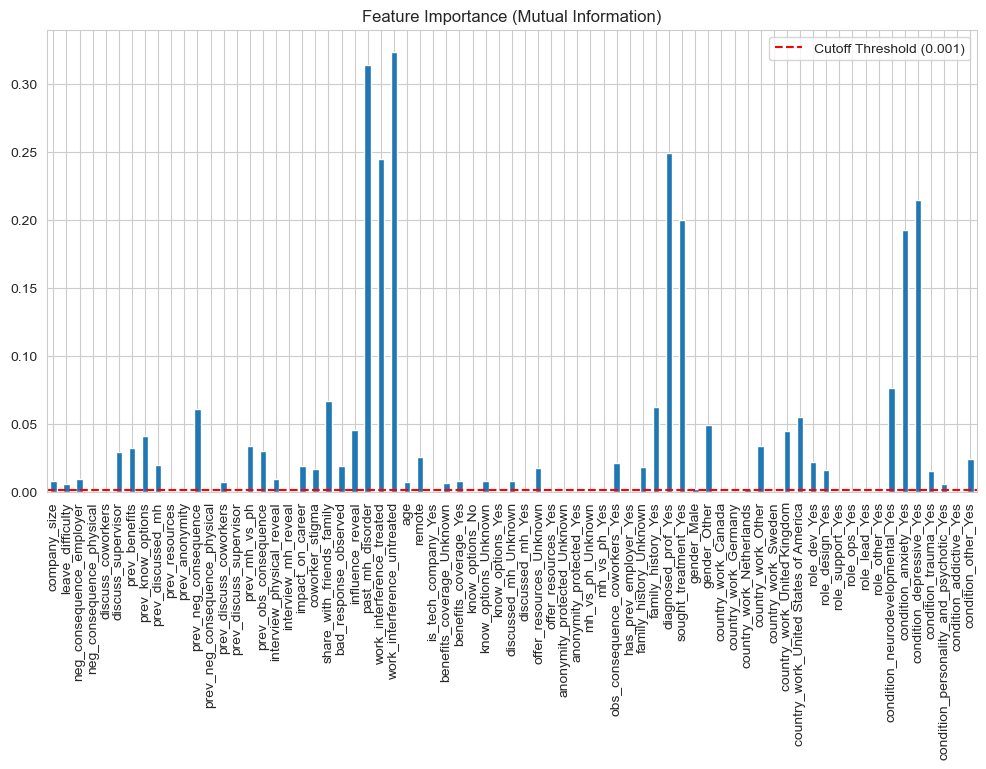

In [135]:
plt.figure(figsize=(12, 6))
series.plot(kind='bar')
plt.title("Feature Importance (Mutual Information)")
plt.axhline(y=0.001, color='r', linestyle='--', label='Cutoff Threshold (0.001)')
plt.legend()
plt.show()

In [136]:
#Review features with low MI
threshold = 0.001
lower = series[series < threshold].index.tolist()
print(lower)

['neg_consequence_physical', 'discuss_coworkers', 'prev_resources', 'prev_anonymity', 'prev_neg_consequence_physical', 'prev_discuss_supervisor', 'interview_mh_reveal', 'is_tech_company_Yes', 'know_options_No', 'know_options_Yes', 'discussed_mh_Yes', 'offer_resources_Yes', 'anonymity_protected_Unknown', 'anonymity_protected_Yes', 'mh_vs_ph_Unknown', 'mh_vs_ph_Yes', 'has_prev_employer_Yes', 'country_work_Canada', 'country_work_Germany', 'country_work_Sweden', 'role_support_Yes', 'role_ops_Yes', 'role_lead_Yes', 'role_other_Yes', 'condition_addictive_Yes']


In [137]:
# Cramer's V Function
def cramers_v(x, y):
    matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(matrix)[0]
    n = matrix.sum().sum()
    return np.sqrt((chi2 / n) / (min(matrix.shape) - 1))

In [138]:
#Collinearity check (> 0.80)
valid = [c for c in X_reduced.columns if c in df_mix.columns]
drop = set()

for i, j in combinations(valid, 2):
    v = cramers_v(df_mix[i], df_mix[j])
    if v > 0.80:
        score_1 = series.get(i, 0)
        score_2 = series.get(j, 0)

        lowest = min(score_1, score_2)
        if lowest == score_1:
            drop.add(i)
        else:
            drop.add(j)

In [139]:
#Drop columns that qualify
df_mix = df_mix.drop(columns=drop)
df_num = df_num.drop(columns=drop)
print(df_mix.shape, df_num.shape)

(1112, 57) (1112, 72)


*Note that when the analysis was performed, none of the columns qualified and therefore the shape remained the same for both versions of the dataset.*

In [140]:
#Save processed datasets into CSV files
df_mix.to_csv('../data/processed/df_cat.csv', index=False, quoting=csv.QUOTE_ALL)
df_num.to_csv('../data/processed/df_num.csv', index=False, quoting=csv.QUOTE_ALL)

### 2.4 Dimensionality Reduction Strategy
#### 2.4.1 Factor Analysis of Mixed Data (FAMD)
FAMD serves as a diagnostic tool to visualize variance dominance. Initial projections indicated that "Previous Employer" features disproportionately drove global variance, effectively splitting the population based on employment history rather than mental health status. These features were subsequently excluded to focus on *current* workplace dynamics.

In [141]:
#Load categorical CSV
df = pd.read_csv('../data/processed/df_cat.csv', keep_default_na=False, na_values='')
cat_cols = df.select_dtypes(exclude=['number']).columns
df[cat_cols] = df[cat_cols].astype('category')

In [142]:
#Initial FAMD
famd = prince.FAMD(n_components=2, n_iter=3, copy=True, check_input=True, random_state=42)
famd = famd.fit(df)

In [143]:
#Percentage of variance by FAMD component
print(famd.eigenvalues_summary)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0            344.290         9.91%                      9.91%
1            203.094         5.85%                     15.76%


In [144]:
#Loadings matrix
loadings = famd.column_coordinates_
print(loadings[0].abs().sort_values(ascending=False).head(10))
print(loadings[1].abs().sort_values(ascending=False).head(10))

variable
prev_know_options                0.986906
prev_obs_consequence             0.986802
prev_resources                   0.985944
prev_benefits                    0.985857
prev_neg_consequence             0.985774
prev_discussed_mh                0.985585
prev_mh_vs_ph                    0.985582
prev_anonymity                   0.985442
prev_neg_consequence_physical    0.985440
prev_discuss_supervisor          0.985438
Name: 0, dtype: float64
variable
work_interference_untreated    0.526433
curr_mh_disorder               0.486329
past_mh_disorder               0.479181
diagnosed_prof                 0.447228
work_interference_treated      0.435871
sought_treatment               0.421763
condition_depressive           0.350062
neg_consequence_employer       0.269798
condition_anxiety              0.258035
influence_reveal               0.240557
Name: 1, dtype: float64


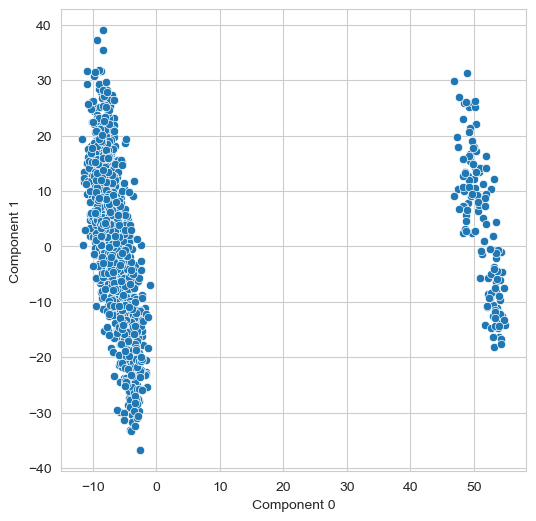

In [145]:
#Initial FAMD plot
coords = famd.row_coordinates(df)
plt.figure(figsize=(6, 6))
sns.scatterplot(data=coords, x=0, y=1)
plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.show()

In [146]:
#Column contributions
contributions = famd.column_contributions_
print(contributions.head())

#Top 5 contributors to horizontal variance
print(contributions[0].sort_values(ascending=False).head(5))

component                     0         1
variable                                 
age                    0.000096  0.000008
anonymity_protected    0.000031  0.000099
bad_response_observed  0.000111  0.001153
benefits_coverage      0.000033  0.000185
company_size           0.000018  0.000110
variable
prev_know_options       0.002866
prev_obs_consequence    0.002866
prev_resources          0.002864
prev_benefits           0.002863
prev_neg_consequence    0.002863
Name: 0, dtype: float64


In [147]:
#Crosstab verification
for col in df.select_dtypes(include='category').columns:
    crosstab = pd.crosstab(df[col], coords[0] > 0)
    print(col)
    print(crosstab)

is_tech_company
0                False  True 
is_tech_company              
No                 209     32
Yes                776     95
benefits_coverage
0                  False  True 
benefits_coverage              
No                   248     42
Unknown              272     36
Yes                  465     49
know_options
0             False  True 
know_options              
N/A             110     16
No              306     41
Unknown         300     43
Yes             269     27
discussed_mh
0             False  True 
discussed_mh              
No              699     96
Unknown          92      7
Yes             194     24
offer_resources
0                False  True 
offer_resources              
No                 449     69
Unknown            281     31
Yes                255     27
anonymity_protected
0                    False  True 
anonymity_protected              
No                      65     17
Unknown                643     81
Yes                    277     29
mh_vs_p

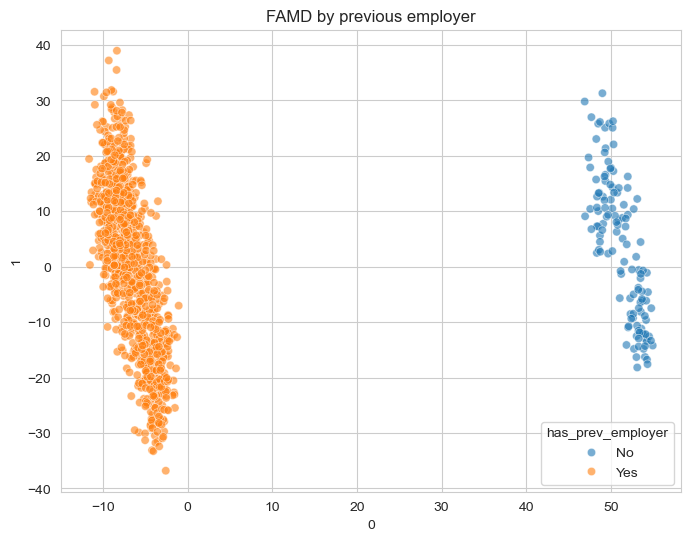

In [148]:
#FAMD plot colored by previous employer values
coords['has_prev_employer'] = df['has_prev_employer'].values

plt.figure(figsize=(8, 6))
sns.scatterplot(data=coords, x=0, y=1, hue='has_prev_employer', alpha=0.6)
plt.title("FAMD by previous employer")
plt.show()

In [149]:
#FAMD plot after dropping previous employer column
df_filter = df.drop(columns=['has_prev_employer'])
famd_filter = prince.FAMD(n_components=2).fit(df_filter)
famd_filter.plot(df_filter)

alt.LayerChart(...)

In [150]:
#FAMD column contributions after dropping previous employer column
contributions_filter = famd_filter.column_contributions_

#Component 0 inertia
inertia_c0 = contributions_filter[0].sort_values(ascending=False).head(10)

#Component 1 inertia
inertia_c1 = contributions_filter[1].sort_values(ascending=False).head(10)

print(inertia_c0)
print(inertia_c1)

variable
prev_know_options                0.003153
prev_obs_consequence             0.003153
prev_resources                   0.003149
prev_neg_consequence             0.003148
prev_benefits                    0.003148
prev_mh_vs_ph                    0.003147
prev_discussed_mh                0.003147
prev_discuss_supervisor          0.003147
prev_neg_consequence_physical    0.003147
prev_anonymity                   0.003147
Name: 0, dtype: float64
variable
work_interference_untreated    0.002607
curr_mh_disorder               0.002410
past_mh_disorder               0.002363
diagnosed_prof                 0.002207
work_interference_treated      0.002156
sought_treatment               0.002078
condition_depressive           0.001735
neg_consequence_employer       0.001371
condition_anxiety              0.001281
influence_reveal               0.001197
Name: 1, dtype: float64


In [151]:
#Drop all previous employer data from clustering dataframe
prev_cols = [col for col in df.columns if 'prev' in col]
df = df.drop(columns=prev_cols + ['has_prev_employer'], errors='ignore')
df.shape

(1112, 45)

In [152]:
#Final FAMD
famd = prince.FAMD(n_components=2, n_iter=5, random_state=42)
famd = famd.fit(df)

In [153]:
#Final Eigenvalues
print(famd.eigenvalues_summary)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0            148.389         7.49%                      7.49%
1            109.204         5.51%                     13.00%


In [154]:
#Final loadings 
loadings = famd.column_coordinates_
print(loadings[0].abs().sort_values(ascending=False).head(10))
print(loadings[1].abs().sort_values(ascending=False).head(10))

variable
work_interference_untreated    0.679216
past_mh_disorder               0.643146
curr_mh_disorder               0.623086
diagnosed_prof                 0.594422
work_interference_treated      0.582340
sought_treatment               0.568757
condition_depressive           0.441432
condition_anxiety              0.324633
family_history                 0.287831
bad_response_observed          0.198003
Name: 0, dtype: float64
variable
discuss_supervisor           0.479315
neg_consequence_employer     0.455239
discuss_coworkers            0.418960
impact_on_career             0.362434
coworker_stigma              0.346578
leave_difficulty             0.315485
mh_vs_ph                     0.300453
share_with_friends_family    0.227881
neg_consequence_physical     0.216333
anonymity_protected          0.172836
Name: 1, dtype: float64


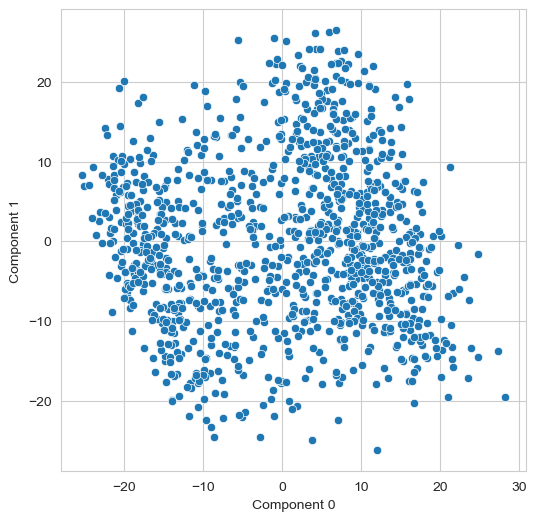

In [155]:
#Final FAMD plot
coords = famd.row_coordinates(df)
plt.figure(figsize=(6, 6))
sns.scatterplot(data=coords, x=0, y=1)
plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.show()

In [156]:
#Final column contributions
contributions = famd.column_contributions_
print(contributions[0].sort_values(ascending=False).head(5))
print(contributions[1].sort_values(ascending=False).head(5))

variable
work_interference_untreated    0.004577
past_mh_disorder               0.004334
curr_mh_disorder               0.004199
diagnosed_prof                 0.004006
work_interference_treated      0.003924
Name: 0, dtype: float64
variable
discuss_supervisor          0.004389
neg_consequence_employer    0.004169
discuss_coworkers           0.003836
impact_on_career            0.003319
coworker_stigma             0.003174
Name: 1, dtype: float64


#### 2.4.2 t-SNE Manifold Learning
To validate the structure of the refined feature space, **t-SNE** with a pre-calculated **Gower Distance** matrix is employed. The resulting visualization supports the "spectrum hypothesis," revealing a continuous gradient of mental health profiles rather than isolated, disjointed clusters.

In [157]:
#Gower Distance Matrix
df_gower = df.copy()
cat_cols = df_gower.select_dtypes(include=['category']).columns
df_gower[cat_cols] = df_gower[cat_cols].astype(object)

gower_dist = gower.gower_matrix(df_gower)

In [158]:
print(gower_dist.shape)
print(gower_dist.min())
print(gower_dist.max())

(1112, 1112)
0.0
0.77623785


In [159]:
#TSNE
tsne = TSNE(n_components=2, metric='precomputed', init = 'random', perplexity=40, random_state=42, n_jobs=-1)

result = tsne.fit_transform(gower_dist)
df_tsne = pd.DataFrame(result, columns=['dim_1', 'dim_2'])

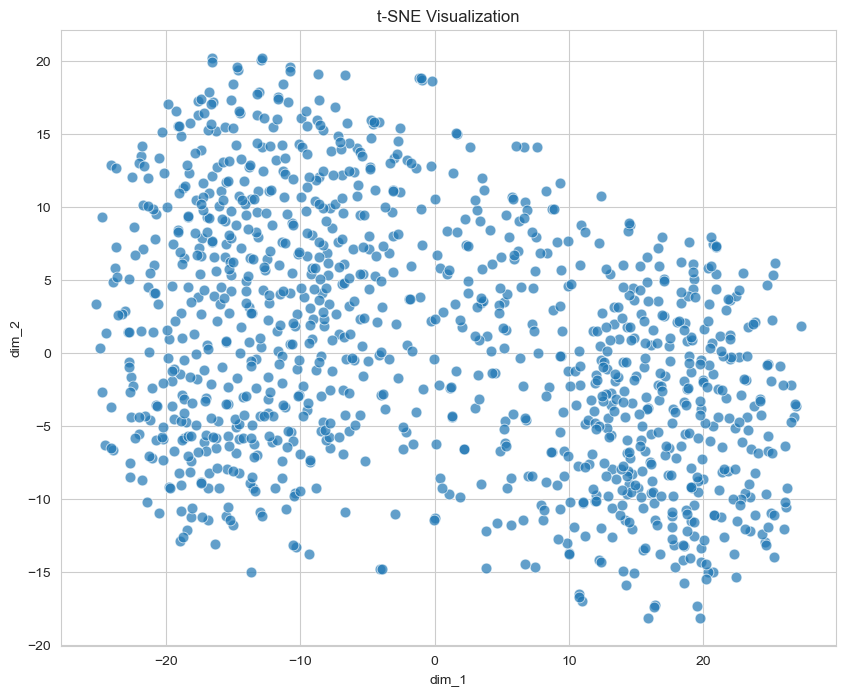

In [160]:
#t-SNE Visualization of data (pre-clustering)
plt.figure(figsize=(10, 8))
sns.scatterplot(x='dim_1', y='dim_2', data=df_tsne, alpha=0.7, s=60)
plt.title('t-SNE Visualization')
plt.show()

### 3.2 Optimal Cluster Determination
* **Elbow Method:** Applied to the cost function (inertia).
* **Cluster Stability:** Validated via **Adjusted Rand Index (ARI)** across multiple random initializations.
* **Hierarchical Clustering:** Used as a secondary structural validation method.

Results indicate **$k=3$** provides the optimal balance between statistical robustness ($ARI=0.90$) and business interpretability.

In [161]:
#Elbow Method
cats = [df.columns.get_loc(c) for c in df.select_dtypes(include='category').columns]

costs = []
k_range = range(2, 8)

print("Running Elbow Method...")
for k in k_range:
    try:
        kproto = KPrototypes(n_clusters=k, init='Huang', n_init=3, verbose=0, random_state=42, gamma=1.5)
        kproto.fit(df.values, categorical=cats)
        costs.append(kproto.cost_)
        print(f"  k={k}: Cost={kproto.cost_:.2f}")
    except Exception as e:
        print(f"  k={k}: Failed - {e}")

Running Elbow Method...
  k=2: Cost=26868.29
  k=3: Cost=25100.85
  k=4: Cost=24057.61
  k=5: Cost=23095.36
  k=6: Cost=22479.87
  k=7: Cost=21993.17


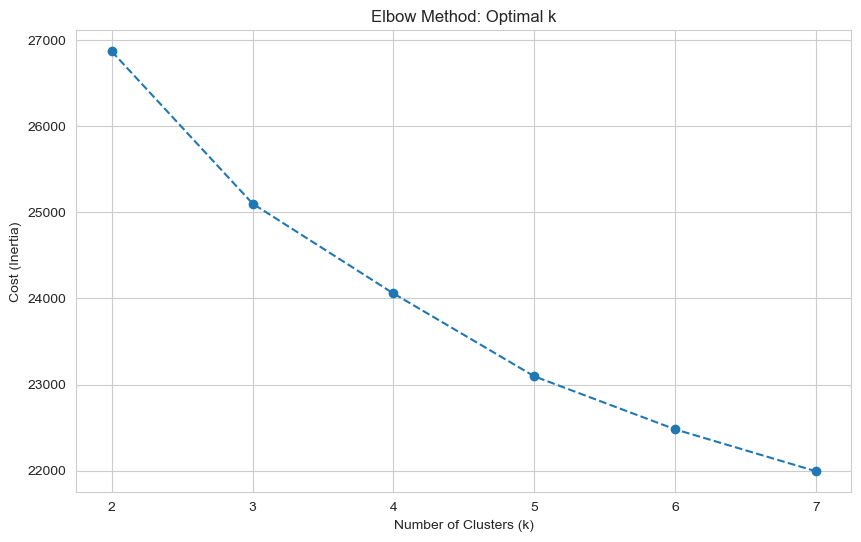

In [162]:
#Elbow Method Plot
plt.figure(figsize=(10, 6))
plt.plot(k_range, costs, marker='o', linestyle='--')
plt.title('Elbow Method: Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost (Inertia)')
plt.grid(True)
plt.show()

In [163]:
#Hierarchical Clustering
gower_cond = squareform(gower_dist)
Z = linkage(gower_cond, method='complete')

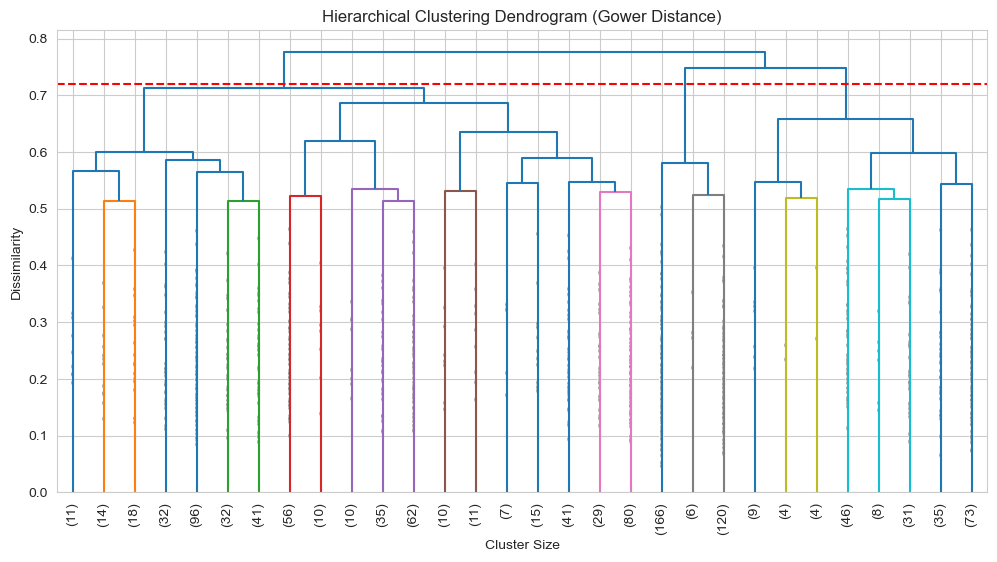

In [164]:
#Hierarchical Clustering Plot
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90, leaf_font_size=10, show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Gower Distance)')
plt.xlabel('Cluster Size')
plt.ylabel('Dissimilarity')
plt.axhline(y=0.72, color='r', linestyle='--')
plt.show()

In [165]:
#Silhouette Score
def calculate_silhouette(df, k, cats, gower_dist):
    kp = KPrototypes(n_clusters=k, init='Huang', n_init=5, verbose=0, random_state=42, gamma=1.5)
    labels = kp.fit_predict(df, categorical=cats)
    score = silhouette_score(gower_dist, labels, metric='precomputed')
    return score, labels


candidates = [2, 3, 4, 5]
print("Silhouette Scores:")
for k in candidates:
    score, _ = calculate_silhouette(df, k, cats, gower_dist)
    print(f'k={k}: {score:.4f}')

Silhouette Scores:
k=2: 0.1900
k=3: 0.1419
k=4: 0.0754
k=5: 0.0551


In [166]:
#Stability Test (Adjusted Rand Index)
def stability(df, k, cats):
    kp1 = KPrototypes(n_clusters=k, init='Huang', n_init=1, random_state=42, gamma=1.5)
    labels1 = kp1.fit_predict(df, categorical=cats)
    
    kp2 = KPrototypes(n_clusters=k, init='Huang', n_init=1, random_state=101, gamma=1.5)
    labels2 = kp2.fit_predict(df, categorical=cats)
    
    index = adjusted_rand_score(labels1, labels2)
    
    print(f'Stability Index for k = {k}: {index:.4f}')

In [167]:
for k in candidates:
    stability(df, k, cats)

Stability Index for k = 2: 1.0000
Stability Index for k = 3: 0.8998
Stability Index for k = 4: 0.5107
Stability Index for k = 5: 0.5134


### 2.5 Clustering Algorithm: K-Prototypes
Standard K-Means is unsuitable due to the undefined Euclidean distance for categorical variables. **K-Prototypes** is selected as the primary algorithm, extending K-Means by combining:
* **Euclidean distance** for numerical features (Age).
* **Matching Dissimilarity** for categorical features (Benefits, Anonymity).

In [168]:
#Final K-Protoypes
best_k = 3
best_gamma = 1.5

kp = KPrototypes(n_clusters=best_k, gamma=best_gamma, init='Huang', n_init=10, verbose=0, random_state=42)
cluster_labels = kp.fit_predict(df.values, categorical=cats)

df_final = df_mix.copy()
df_final['Cluster'] = cluster_labels

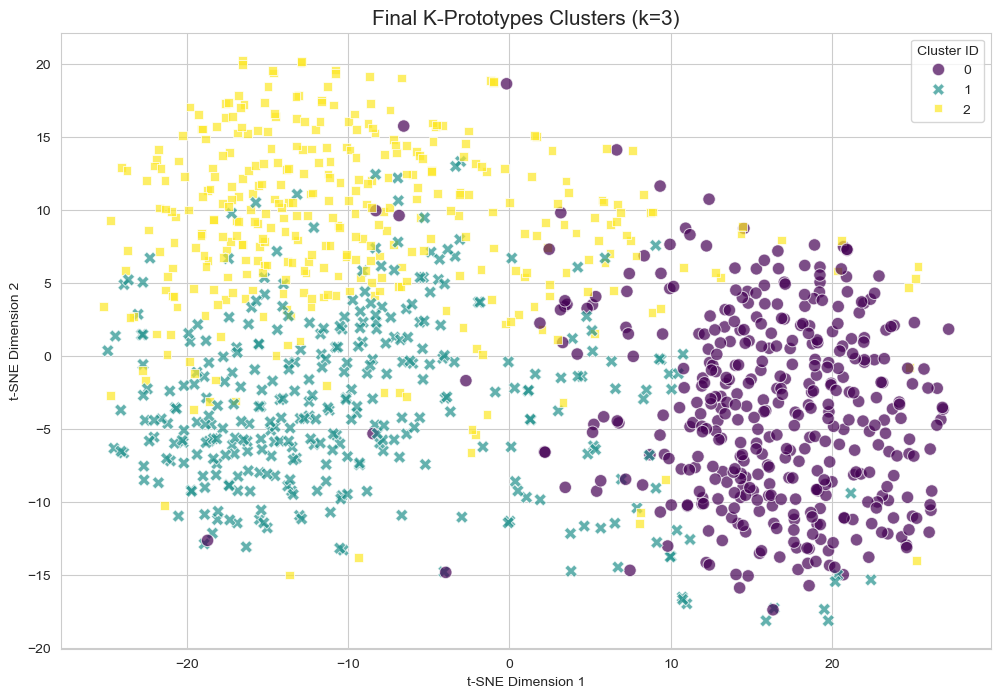

In [169]:
#Final Clustering Visualization (t-SNE on K-Prototypes)
tsne = TSNE(
    n_components=2, 
    metric='precomputed',
    init='random', 
    perplexity=40, 
    random_state=42, 
    n_jobs=-1
)

result = tsne.fit_transform(gower_dist)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=result[:, 0], 
    y=result[:, 1],
    hue=cluster_labels,
    palette='viridis', 
    style=cluster_labels,
    s=80, 
    alpha=0.7
)

plt.title(f'Final K-Prototypes Clusters (k={best_k})', fontsize=15)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster ID')
plt.show()


In [170]:
#Cluster Distribution
print(df_final['Cluster'].value_counts().sort_index())

Cluster
0    396
1    344
2    372
Name: count, dtype: int64


In [171]:
#Save clustered dataset to CSV
df_final.to_csv('../data/processed/df_clustered.csv', index=False, quoting=csv.QUOTE_ALL)

In [172]:
#Cluster Profile Function
def profiles(df, cluster_col='Cluster'):
    cols = df.select_dtypes(include=['object', 'category']).columns
    cols = [c for c in cols if c not in ['Unnamed: 0']]
    
    nums = df.select_dtypes(include=['number']).columns
    nums = [c for c in nums if c not in [cluster_col, 'age']]
    
    modes = df.groupby(cluster_col)[cols].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    mean = df.groupby(cluster_col)['age'].mean().round(2) * 100
    mean = mean.astype(int)
    means = df.groupby(cluster_col)[nums].mean().round().astype(int)
    
    return pd.concat([mean, modes, means], axis=1).sort_index().T

In [173]:
#Cluster Profiles
cluster_stats = profiles(df_final)
display(cluster_stats)

Cluster                                                     0  \
age                                                        26   
is_tech_company                                           Yes   
benefits_coverage                                     Unknown   
know_options                                               No   
discussed_mh                                               No   
offer_resources                                            No   
anonymity_protected                                   Unknown   
mh_vs_ph                                              Unknown   
obs_consequence_coworkers                                  No   
has_prev_employer                                         Yes   
family_history                                             No   
diagnosed_prof                                             No   
sought_treatment                                           No   
gender                                                   Male   
country_work                         United States of America   
role_dev                                                  Yes   
role_design                                                No   
role_support                                               No   
role_ops                                                   No   
role_lead                                                  No   
role_other                                                 No   
condition_neurodevelopmental                               No   
condition_anxiety                                          No   
condition_depressive                                       No   
condition_trauma                                           No   
condition_personality_and_psychotic                        No   
condition_addictive                                        No   
condition_other                                            No   
company_size                                                3   
leave_difficulty                                            1   
neg_consequence_employer                                    1   
neg_consequence_physical                                    0   
discuss_coworkers                                           1   
discuss_supervisor                                          1   
prev_benefits                                               1   
prev_know_options                                           0   
prev_discussed_mh                                           0   
prev_resources                                              0   
prev_anonymity                                              1   
prev_neg_consequence                                        1   
prev_neg_consequence_physical                               0   
prev_discuss_coworkers                                      1   
prev_discuss_supervisor                                     1   
prev_mh_vs_ph                                               1   
prev_obs_consequence                                        0   
interview_physical_reveal                                   1   
interview_mh_reveal                                         1   
impact_on_career                                            1   
coworker_stigma                                             1   
share_with_friends_family                                   2   
bad_response_observed                                       1   
influence_reveal                                            0   
past_mh_disorder                                            0   
curr_mh_disorder                                            0   
work_interference_treated                                  -1   
work_interference_untreated                                -1   
remote                                                      1   

Cluster                                                     1  \
age                                                        27   
is_tech_company                                           Yes   
benefits_coverage                 

In [174]:
cluster_stats.to_csv('../data/processed/cluster_profiles.csv')

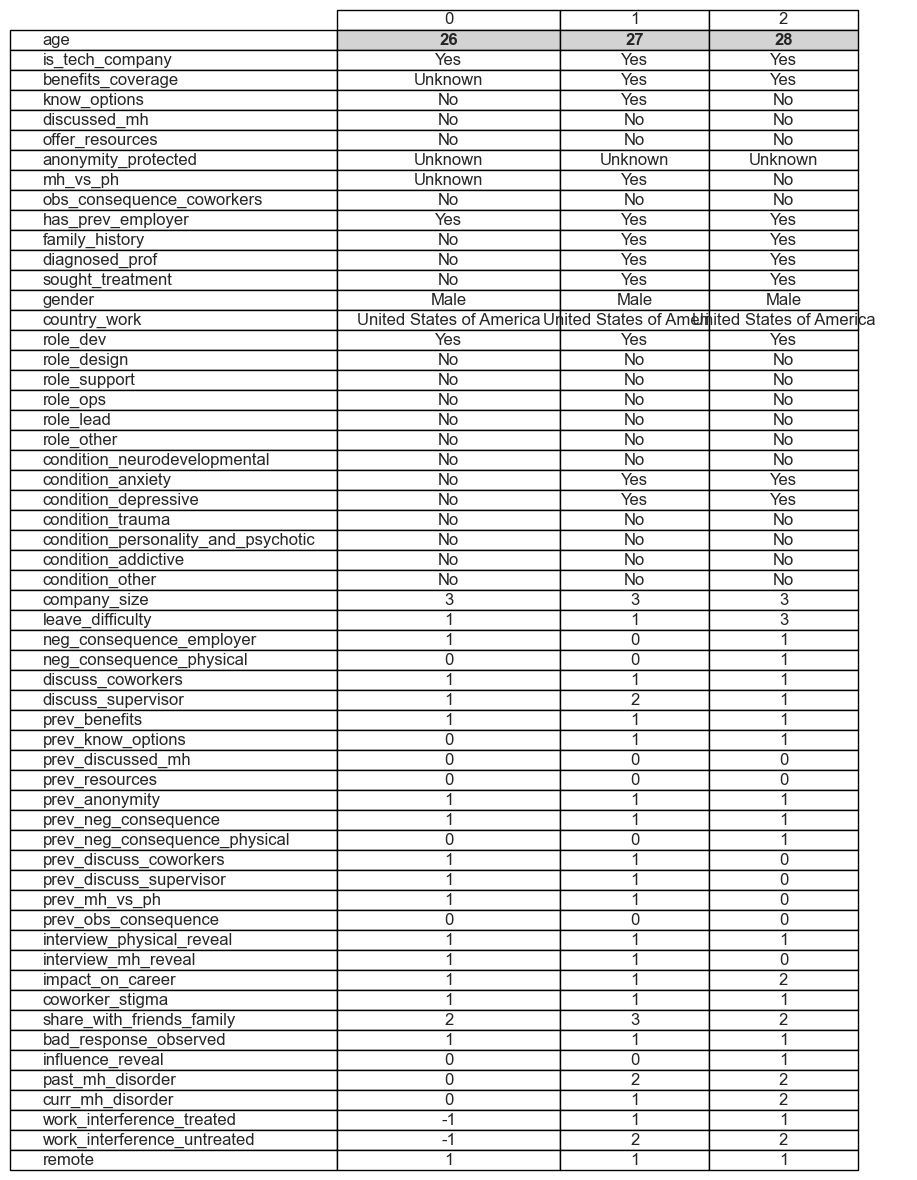

In [175]:
#Figure A13 (case study)
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')
table = ax.table(cellText=cluster_stats, 
                 loc='center', 
                 cellLoc='center', 
                 colWidths=[0.3, 0.2, 0.2]) 


table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2) 

for i, cell in enumerate(table.get_celld().values()):
    if i < 3:  # First row (headers)
        cell.set_facecolor('#d3d3d3')  # Light gray
        cell.set_text_props(weight='bold')


plt.savefig('../figures/profile_table.png', bbox_inches='tight', dpi=300)
plt.show()

In [176]:
#Cluster Features Function
def features(df, cluster_col='Cluster', n=5, min_pct=25):
    feats = {}
    features_only = df.drop(columns=[cluster_col])
    global_props = features_only.apply(lambda x: x.value_counts(normalize=True))
    
    for cluster in sorted(df[cluster_col].unique()):
        subset = df[df[cluster_col] == cluster]
        cluster_props = subset.drop(columns=[cluster_col]).apply(lambda x: x.value_counts(normalize=True))
        diff = cluster_props - global_props
        diff_df = diff.unstack().reset_index()
        diff_df.columns = ['Feature', 'Value', 'Gap']
        
        cluster_prev = cluster_props.unstack().reset_index()
        cluster_prev.columns = ['Feature', 'Value', 'Prevalence']
        
        final_diff = diff_df.merge(cluster_prev, on=['Feature', 'Value'])
        filtered = final_diff[(final_diff['Prevalence'] >= (min_pct/100)) & (final_diff['Gap'] > 0)]
        feats[cluster] = filtered.sort_values('Gap', ascending=False).head(n)   
    return feats

In [177]:
#Cluster Feature Summaries
characteristics = features(df_final)
for cluster, traits in characteristics.items():
    print(f"\nCluster {cluster}")
    for _, row in traits.iterrows():
        print(f"{row['Feature'].replace('_', ' ').title()} = {row['Value']}: +{row['Gap']:.1%} ({row['Prevalence']:.1%} of group)")
        #Distinguishing feature = Most common value of feature for that cluster: +How much more common it is than global average% (Percentage of cluster with that value)


Cluster 0
Work Interference Untreated = -1: +57.9% (91.2% of group)
Work Interference Treated = -1: +55.1% (94.4% of group)
Curr Mh Disorder = 0: +46.8% (85.4% of group)
Diagnosed Prof = No: +46.7% (97.0% of group)
Sought Treatment = No: +45.5% (88.1% of group)

Cluster 1
Neg Consequence Employer = 0: +27.3% (65.7% of group)
Discuss Supervisor = 2: +27.0% (64.5% of group)
Diagnosed Prof = Yes: +25.6% (75.3% of group)
Sought Treatment = Yes: +24.6% (82.0% of group)
Past Mh Disorder = 2: +23.3% (74.4% of group)

Cluster 2
Past Mh Disorder = 2: +27.1% (78.2% of group)
Impact On Career = 2: +27.0% (72.8% of group)
Diagnosed Prof = Yes: +26.1% (75.8% of group)
Coworker Stigma = 2: +25.7% (54.8% of group)
Sought Treatment = Yes: +25.7% (83.1% of group)


<Figure size 1000x600 with 0 Axes>

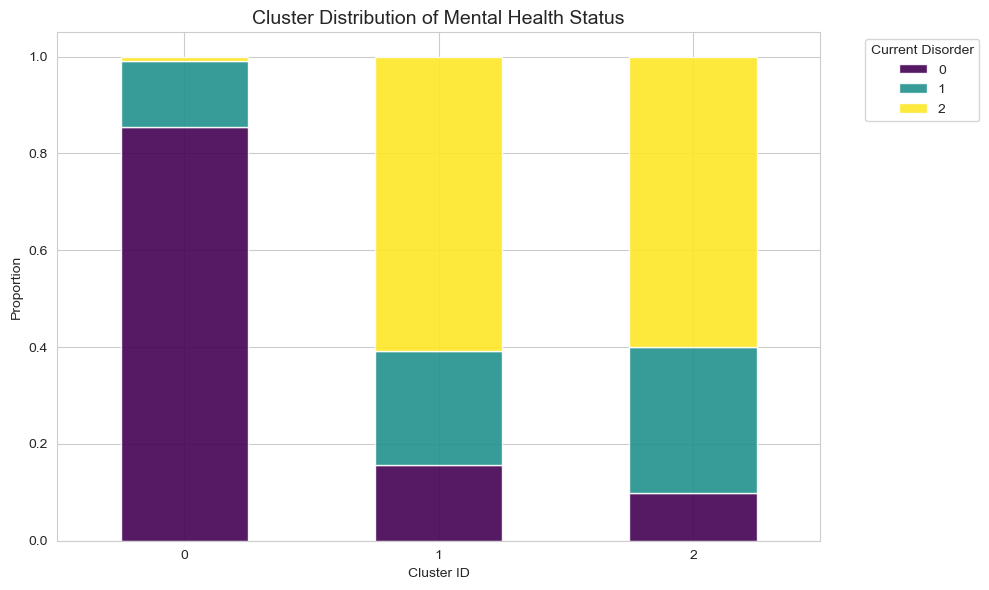

In [178]:
#Cluster Distribution of Mental Health Status Chart
plt.figure(figsize=(10, 6))
cross = pd.crosstab(df_final['Cluster'], df_final['curr_mh_disorder'], normalize='index')

# Plot
ax = cross.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6), alpha=0.9)
plt.title('Cluster Distribution of Mental Health Status', fontsize=14)
plt.xlabel('Cluster ID')
plt.ylabel('Proportion')
plt.legend(title='Current Disorder', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [179]:
#Silhouette Score per Cluster
sample_silhouette_values = silhouette_samples(gower_dist, df_final['Cluster'], metric='precomputed')
df_final['silhouette_score'] = sample_silhouette_values

cluster_strength = df_final.groupby('Cluster')['silhouette_score'].mean().reset_index()
cluster_strength.columns = ['Cluster', 'Mean Silhouette']
display(cluster_strength)

Cluster  Mean Silhouette
0        0         0.246645
1        1         0.082233
2        2         0.085692